## Modifying Notebook display

In [1]:
from IPython.display import display, HTML

display(HTML(data="""
<style>
    .container#notebook-container    { width: 95%;}
    div#menubar-container     { width: 95%; }
    div#maintoolbar-container { width: 95%; }
</style>
<script>
    document.getElementById("notebook-container").style.margin = "auto";
</script>
"""))

## For running the notebook as Google Colab Instance

``
#mounting the google drive for accessing other necessary files
from google.colab import drive
drive.mount('/content/gdrive')
``

``
#Checking the available files in the "Colab Notebooks" folder of the google drive
!ls /content/gdrive/My\ Drive/Colab\ Notebooks/Handwritten\ Digit\ Recognition
``

``
import sys
``

``
#changing the current working directory to "Colab Notebooks" folder in the google drive
sys.path.append('/content/gdrive/My Drive/Colab Notebooks/Handwritten Digit Recognition')
``

## For running the notebook as Kaggle Kernel

change directory to the dataset where our custom scripts are uploaded

> ``os.chdir("/kaggle/input/handwritten-digit-recognition")``

***handwritten-digit-recognition*** is simply a folder name. It can vary based on the dataset you create in kaggle while uploading the python scripts.


load custom module or files or dataset

> ``from  dataset import load_dataset, train_dev_split, prep_dataset`` <br>
> ```from dataset import visualize_data_distribution, visualize_dataset```


reset our working directory

> ```os.chdir("/kaggle/working/")```

**NOTE:** The ***input directory*** is Read-Only. So, we must switch back to the ***working directory*** for performing any other operation that requires write access. Make sure this note book runs as a part of the dataset you create as said above because all the custom modules are uploaded there. 


## Importing Dependencies

In [2]:
# Python Standard Libraries for importing data from binary file
import time    #for calculating time

#core packages
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Ellipse

# os.chdir("/kaggle/input/handwritten-digit-recognition")

#custom module
from  dataset import load_dataset, train_dev_split, prep_dataset
from dataset import visualize_data_distribution, visualize_dataset

from ffnn import init_layers, init_hyperParams
from ffnn import train, evaluate

from ModelUtils import convert_time
from ModelUtils import save_model, load_model


# # reset our working directory
# os.chdir("/kaggle/working/")


# np.random.seed(1)
%matplotlib inline

In [3]:
dataset_size_in_per = 50

train_x_orig, train_y_orig, test_x_orig, test_y_orig = load_dataset(dataset = "mnist", size_in_per = dataset_size_in_per)

print("Sample Size : %d%%\n"%(dataset_size_in_per))
print("Data\t\t\t","Datatype\t\t","Dataset Size")
print("=================================================================")
print("Training Set Images:\t" + str(type(train_x_orig))+"\t",str(train_x_orig.shape))
print("Training Set Labels:\t" + str(type(train_y_orig))+"\t",str(train_y_orig.shape))
print("Test Set Images:\t" + str(type(test_x_orig))+"\t",str(test_x_orig.shape))
print("Test Set Labels:\t" + str(type(test_y_orig))+"\t",str(test_y_orig.shape))
print("=================================================================")

Sample Size : 50%

Data			 Datatype		 Dataset Size
Training Set Images:	<class 'numpy.ndarray'>	 (30000, 28, 28)
Training Set Labels:	<class 'numpy.ndarray'>	 (30000, 1)
Test Set Images:	<class 'numpy.ndarray'>	 (5000, 28, 28)
Test Set Labels:	<class 'numpy.ndarray'>	 (5000, 1)


In [4]:
train_x_split, train_y_split, dev_x_split, dev_y_split = train_dev_split(train_x_orig, train_y_orig)

print("Data\t\t\t\t","Datatype\t\t","Shape")
print("========================================================================")
print("Training Set Images:\t\t" + str(type(train_x_split))+"\t",str(train_x_split.shape))
print("Training Set Labels:\t\t" + str(type(train_y_split))+"\t",str(train_y_split.shape))
print("Development Set Images:\t\t" + str(type(dev_x_split))+"\t",str(dev_x_split.shape))
print("Development Set Labels:\t\t" + str(type(dev_y_split))+"\t",str(dev_y_split.shape))
print("========================================================================")


Data				 Datatype		 Shape
Training Set Images:		<class 'numpy.ndarray'>	 (25000, 28, 28)
Training Set Labels:		<class 'numpy.ndarray'>	 (25000, 1)
Development Set Images:		<class 'numpy.ndarray'>	 (5000, 28, 28)
Development Set Labels:		<class 'numpy.ndarray'>	 (5000, 1)


In [5]:
train_x_norm, train_y_encoded = prep_dataset(train_x_split, train_y_split, num_class = 10)
dev_x_norm, dev_y_encoded= prep_dataset(dev_x_split, dev_y_split, num_class = 10)
test_x_norm, test_y_encoded = prep_dataset(test_x_orig, test_y_orig, num_class = 10)

print("Data\t\t\t","Before Processing\t","After Processing")
print("=================================================================")
print("Training Set Images:\t" + str(train_x_split.shape)+"\t\t"+ str(train_x_norm.shape))
print("Training Set Labels:\t" + str(train_y_split.shape)+"\t\t"+ str(train_y_encoded.shape))
print("Dev Set Images:\t\t" + str(dev_x_split.shape)+"\t\t"+ str(dev_x_norm.shape))
print("Dev Set Labels:\t\t" + str(dev_y_split.shape)+"\t\t"+ str(dev_y_encoded.shape))
print("Test Set Images:\t" + str(test_x_orig.shape)+"\t\t"+ str(test_x_norm.shape))
print("Test Set Labels:\t" + str(test_y_orig.shape)+"\t\t"+ str(test_y_encoded.shape))
print("=================================================================")

Data			 Before Processing	 After Processing
Training Set Images:	(25000, 28, 28)		(784, 25000)
Training Set Labels:	(25000, 1)		(10, 25000)
Dev Set Images:		(5000, 28, 28)		(784, 5000)
Dev Set Labels:		(5000, 1)		(10, 5000)
Test Set Images:	(5000, 28, 28)		(784, 5000)
Test Set Labels:	(5000, 1)		(10, 5000)


## Random Search 2D

### Random Sampling

In [6]:
def sample_network_architecture(search_params,sample_size, num_hidden_units = 'variable', mixed_mode = False):
    hidden_layers_rng = search_params['hidden_layers']
    hidden_units_rng = search_params['hidden_units']

    sample_architectures = []
    while( len(sample_architectures) != sample_size):
        #generating the number of hidden layers
        hidden_layer = np.random.randint(low = hidden_layers_rng[0], high = hidden_layers_rng[1])
        hidden_units = []
        
        #randomizing the variable and constant hidden units size mode
        if mixed_mode:
            num_hidden_units = np.random.choice(['constant','variable'])
        
        if num_hidden_units == 'variable': 
            #generating variable size hidden units based on number of hidden layers 
            for num_layer in range(hidden_layer):
                hidden_unit = np.random.randint(low = hidden_units_rng[0], high = hidden_units_rng[1])
                hidden_unit = (hidden_unit // 100) * 100 #making sure the hidden units are the multiple of 100 for computational ease
                hidden_units.append(hidden_unit)
        elif num_hidden_units == 'constant':
            #generating constant number of hidden units based on the number of hidden layers
            hidden_unit = np.random.randint(low = hidden_units_rng[0], high = hidden_units_rng[1])
            hidden_unit = (hidden_unit // 100) * 100
            hidden_units = [hidden_unit for x in range(1,hidden_layer+1)]

        else:
            raise ValueError("Number of hidden units can be variable or constant only.")
        
        #making sure no duplicate architecture is present in the sample
        if hidden_units not in sample_architectures:
            sample_architectures.append(hidden_units)
        
    assert(len(sample_architectures) == sample_size) , 'Samples less than required'
    
    return sample_architectures

In [7]:
#@title Default title text
def search_summary(score, architectures, top_best = 5):
    good_scs = []
    good_archs = []
    
    #retriving best score and architectures
    sorted_score_index = [b[0] for b in sorted(enumerate(score),key=lambda i:i[1], reverse = True)]
    good_scs = [np.squeeze(score[i]) for i in sorted_score_index[:top_best]]
    good_archs = [architectures[i] for i in sorted_score_index[:top_best]]
    
    print("Top " + str(top_best) + " Best Architectures\n")
    print("=================+===============+====================================")
    print(" Val Accuracy\t | Hidden Layers | Hidden Units ")
    print("=================+===============+====================================")

    for ind,sc in enumerate(good_scs):
        print(" %.5f\t |  %d\t\t | %s "%( sc, len(good_archs[ind]) , good_archs[ind] ))

    print("=================+===============+====================================")
        
    print("\nBest Score: %.6f "%(good_scs[0]))
    print("Best Architcture: " + str(good_archs[0]) )
    
    #best hyper parameter combinations
    best_comb = {"architecture": good_archs[0],
                 "score": good_scs[0]}
    
    return best_comb


In [8]:
def network_architecture_search(search_params, sample_size = 100, with_summary = True):
    
    #generating Samples for two input parameters
    architectures = sample_network_architecture(search_params,sample_size = sample_size, mixed_mode = True)
        
    score = []
    best_comb = {}

    #constants
    learning_rate = 0.01
    epoch = 3
    minibatch_size = 128

    toc = time.time()
    for i in range(sample_size):
        print("\nSample: %d | Hidden Layers:%d | Hidden Units: %s "%(i+1, len(architectures[i]), str(architectures[i])))
        print("="*120)
        
        keep_probs = [0.7 for x in range(len(architectures[i]))]

        layers_dim = init_layers(784, 10, hidden_layers = architectures[i])
        hyperParams = init_hyperParams(alpha = learning_rate, num_epoch = epoch, minibatch_size = minibatch_size, keep_probs = keep_probs)
        history = train(train_x_norm, train_y_encoded, dev_x_norm, dev_y_encoded,layers_dim, hyperParams, initialization = "he", optimizer = 'adam',regularizer = "dropout", verbose = 3)
        
        val_acc = history["val_accuracy"][-1]
        score.append(val_acc)
        
        #freeing memory
        layers_dim = hyperParams = history = 0
    
    tic = time.time() # for calculating entire search time
    hrs, mins, secs , ms = convert_time((tic - toc)*1000)
    
    print("\n\n %s Total Search Time = %dhr %dmins %dsecs %.2fms %s \n\n"%(('*' * 20),hrs, mins, secs, ms,('*' * 20)))
    
    if with_summary == True:
        print("Search Summary: \n")
        best_comb = search_summary(score, architectures, top_best = 10)
    
    return score, architectures, best_comb

## Coarse Search

In [9]:

hidden_layers = [1,6]
hidden_units = [300,3000]

search_params = {'hidden_layers':hidden_layers ,
                'hidden_units':hidden_units
}
sample_size = 500

#use sample_size >=200 for better tuning
score, architectures, best_comb = network_architecture_search(search_params , sample_size = sample_size)



Sample: 1 | Hidden Layers:4 | Hidden Units: [2900, 1200, 2400, 2000] 
Training The Model...

Epoch 1/3
196/196 [==================== 100%] - 72.66s 370ms/step | loss: 0.6950 | acc: 0.8098 | val_loss: 0.3730 | val_acc: 0.9052
Epoch 2/3
196/196 [==================== 100%] - 81.12s 413ms/step | loss: 0.3316 | acc: 0.9112 | val_loss: 0.4099 | val_acc: 0.8912
Epoch 3/3
196/196 [==================== 100%] - 77.32s 394ms/step | loss: 0.3400 | acc: 0.9109 | val_loss: 0.4129 | val_acc: 0.8918

Total Training Time = 0hr 4mins 17secs 655.83ms

Sample: 2 | Hidden Layers:1 | Hidden Units: [1500] 
Training The Model...

Epoch 1/3
196/196 [==================== 100%] - 6.99s 35ms/step | loss: 0.2346 | acc: 0.9334 | val_loss: 0.1669 | val_acc: 0.9514
Epoch 2/3
196/196 [==================== 100%] - 7.71s 39ms/step | loss: 0.0960 | acc: 0.9712 | val_loss: 0.1603 | val_acc: 0.9552
Epoch 3/3
196/196 [==================== 100%] - 7.68s 39ms/step | loss: 0.0718 | acc: 0.9789 | val_loss: 0.1511 | val_acc: 0.

Training The Model...

Epoch 1/3
196/196 [==================== 100%] - 157.26s 802ms/step | loss: 0.8735 | acc: 0.7661 | val_loss: 0.6991 | val_acc: 0.8354
Epoch 2/3
196/196 [==================== 100%] - 155.63s 794ms/step | loss: 0.5819 | acc: 0.8529 | val_loss: 0.6197 | val_acc: 0.8602
Epoch 3/3
196/196 [==================== 100%] - 151.45s 772ms/step | loss: 0.5861 | acc: 0.8584 | val_loss: 0.6220 | val_acc: 0.8480

Total Training Time = 0hr 8mins 28secs 100.10ms

Sample: 27 | Hidden Layers:5 | Hidden Units: [2400, 1100, 300, 2600, 400] 
Training The Model...

Epoch 1/3
196/196 [==================== 100%] - 35.69s 182ms/step | loss: 2.4096 | acc: 0.1116 | val_loss: 2.3009 | val_acc: 0.1160
Epoch 2/3
196/196 [==================== 100%] - 35.76s 182ms/step | loss: 2.3059 | acc: 0.1115 | val_loss: 2.3013 | val_acc: 0.1160
Epoch 3/3
196/196 [==================== 100%] - 35.61s 181ms/step | loss: 2.3017 | acc: 0.1116 | val_loss: 2.3007 | val_acc: 0.1160

Total Training Time = 0hr 2mins 1

196/196 [==================== 100%] - 6.08s 31ms/step | loss: 0.3612 | acc: 0.9046 | val_loss: 0.2527 | val_acc: 0.9270
Epoch 2/3
196/196 [==================== 100%] - 6.05s 30ms/step | loss: 0.2011 | acc: 0.9400 | val_loss: 0.2647 | val_acc: 0.9298
Epoch 3/3
196/196 [==================== 100%] - 6.04s 30ms/step | loss: 0.1685 | acc: 0.9523 | val_loss: 0.2331 | val_acc: 0.9380

Total Training Time = 0hr 0mins 21secs 283.30ms

Sample: 52 | Hidden Layers:5 | Hidden Units: [300, 300, 300, 300, 300] 
Training The Model...

Epoch 1/3
196/196 [==================== 100%] - 3.94s 20ms/step | loss: 0.5511 | acc: 0.8306 | val_loss: 0.3639 | val_acc: 0.9128
Epoch 2/3
196/196 [==================== 100%] - 3.92s 20ms/step | loss: 0.3138 | acc: 0.9188 | val_loss: 0.3804 | val_acc: 0.9210
Epoch 3/3
196/196 [==================== 100%] - 3.86s 19ms/step | loss: 0.3204 | acc: 0.9181 | val_loss: 0.3883 | val_acc: 0.9126

Total Training Time = 0hr 0mins 14secs 53.12ms

Sample: 53 | Hidden Layers:4 | Hidde

Training The Model...

Epoch 1/3
196/196 [==================== 100%] - 65.01s 331ms/step | loss: 1.0404 | acc: 0.6329 | val_loss: 0.7978 | val_acc: 0.7200
Epoch 2/3
196/196 [==================== 100%] - 64.66s 329ms/step | loss: 0.7101 | acc: 0.7350 | val_loss: 0.7270 | val_acc: 0.7242
Epoch 3/3
196/196 [==================== 100%] - 64.30s 328ms/step | loss: 0.7153 | acc: 0.7321 | val_loss: 0.8464 | val_acc: 0.7008

Total Training Time = 0hr 3mins 37secs 716.29ms

Sample: 65 | Hidden Layers:2 | Hidden Units: [2500, 400] 
Training The Model...

Epoch 1/3
196/196 [==================== 100%] - 16.02s 81ms/step | loss: 0.4297 | acc: 0.9084 | val_loss: 0.2033 | val_acc: 0.9410
Epoch 2/3
196/196 [==================== 100%] - 15.92s 81ms/step | loss: 0.1286 | acc: 0.9610 | val_loss: 0.1878 | val_acc: 0.9440
Epoch 3/3
196/196 [==================== 100%] - 15.96s 81ms/step | loss: 0.1104 | acc: 0.9670 | val_loss: 0.1731 | val_acc: 0.9476

Total Training Time = 0hr 0mins 54secs 567.19ms

Sample:

196/196 [==================== 100%] - 8.21s 41ms/step | loss: 0.2758 | acc: 0.9293 | val_loss: 0.1617 | val_acc: 0.9518
Epoch 2/3
196/196 [==================== 100%] - 8.11s 41ms/step | loss: 0.0973 | acc: 0.9705 | val_loss: 0.1505 | val_acc: 0.9588
Epoch 3/3
196/196 [==================== 100%] - 8.10s 41ms/step | loss: 0.0769 | acc: 0.9772 | val_loss: 0.1726 | val_acc: 0.9498

Total Training Time = 0hr 0mins 28secs 272.35ms

Sample: 78 | Hidden Layers:3 | Hidden Units: [400, 2200, 2700] 
Training The Model...

Epoch 1/3
196/196 [==================== 100%] - 44.93s 229ms/step | loss: 1.3689 | acc: 0.5262 | val_loss: 1.0826 | val_acc: 0.6092
Epoch 2/3
196/196 [==================== 100%] - 39.63s 202ms/step | loss: 0.9635 | acc: 0.6257 | val_loss: 0.9468 | val_acc: 0.6232
Epoch 3/3
196/196 [==================== 100%] - 39.60s 202ms/step | loss: 0.9071 | acc: 0.6550 | val_loss: 0.9330 | val_acc: 0.6518

Total Training Time = 0hr 2mins 20secs 228.87ms

Sample: 79 | Hidden Layers:2 | Hidden

196/196 [==================== 100%] - 15.60s 79ms/step | loss: 0.4547 | acc: 0.8888 | val_loss: 0.2523 | val_acc: 0.9394
Epoch 2/3
196/196 [==================== 100%] - 15.43s 78ms/step | loss: 0.1851 | acc: 0.9495 | val_loss: 0.2535 | val_acc: 0.9362
Epoch 3/3
196/196 [==================== 100%] - 15.46s 78ms/step | loss: 0.1733 | acc: 0.9538 | val_loss: 0.2984 | val_acc: 0.9244

Total Training Time = 0hr 0mins 53secs 168.46ms

Sample: 91 | Hidden Layers:1 | Hidden Units: [1200] 
Training The Model...

Epoch 1/3
196/196 [==================== 100%] - 5.40s 27ms/step | loss: 0.2423 | acc: 0.9309 | val_loss: 0.1693 | val_acc: 0.9496
Epoch 2/3
196/196 [==================== 100%] - 5.37s 27ms/step | loss: 0.0992 | acc: 0.9697 | val_loss: 0.1708 | val_acc: 0.9532
Epoch 3/3
196/196 [==================== 100%] - 5.41s 27ms/step | loss: 0.0719 | acc: 0.9784 | val_loss: 0.1439 | val_acc: 0.9584

Total Training Time = 0hr 0mins 18secs 853.29ms

Sample: 92 | Hidden Layers:5 | Hidden Units: [1800,

196/196 [==================== 100%] - 6.73s 34ms/step | loss: 0.3399 | acc: 0.9102 | val_loss: 0.2008 | val_acc: 0.9410
Epoch 2/3
196/196 [==================== 100%] - 6.65s 33ms/step | loss: 0.1439 | acc: 0.9565 | val_loss: 0.2175 | val_acc: 0.9406
Epoch 3/3
196/196 [==================== 100%] - 6.68s 34ms/step | loss: 0.1303 | acc: 0.9620 | val_loss: 0.1923 | val_acc: 0.9490

Total Training Time = 0hr 0mins 23secs 376.10ms

Sample: 104 | Hidden Layers:4 | Hidden Units: [2000, 2000, 2000, 2000] 
Training The Model...

Epoch 1/3
196/196 [==================== 100%] - 69.62s 355ms/step | loss: 0.7386 | acc: 0.8013 | val_loss: 0.4181 | val_acc: 0.8896
Epoch 2/3
196/196 [==================== 100%] - 69.01s 352ms/step | loss: 0.3913 | acc: 0.8942 | val_loss: 0.4444 | val_acc: 0.8764
Epoch 3/3
196/196 [==================== 100%] - 70.53s 359ms/step | loss: 0.3622 | acc: 0.9032 | val_loss: 0.4279 | val_acc: 0.8910

Total Training Time = 0hr 3mins 55secs 517.88ms

Sample: 105 | Hidden Layers:5

Training The Model...

Epoch 1/3
196/196 [==================== 100%] - 99.01s 505ms/step | loss: 0.6558 | acc: 0.8483 | val_loss: 0.3544 | val_acc: 0.9078
Epoch 2/3
196/196 [==================== 100%] - 98.86s 504ms/step | loss: 0.2748 | acc: 0.9242 | val_loss: 0.3221 | val_acc: 0.9084
Epoch 3/3
196/196 [==================== 100%] - 98.62s 503ms/step | loss: 0.2632 | acc: 0.9307 | val_loss: 0.3020 | val_acc: 0.9226

Total Training Time = 0hr 5mins 23secs 405.82ms

Sample: 129 | Hidden Layers:4 | Hidden Units: [2300, 1800, 2900, 2000] 
Training The Model...

Epoch 1/3
196/196 [==================== 100%] - 91.85s 468ms/step | loss: 0.7653 | acc: 0.7977 | val_loss: 0.4689 | val_acc: 0.8688
Epoch 2/3
196/196 [==================== 100%] - 91.84s 468ms/step | loss: 0.3627 | acc: 0.9059 | val_loss: 0.3829 | val_acc: 0.9092
Epoch 3/3
196/196 [==================== 100%] - 91.80s 468ms/step | loss: 0.3306 | acc: 0.9172 | val_loss: 0.3829 | val_acc: 0.9138

Total Training Time = 0hr 5mins 1secs 7

196/196 [==================== 100%] - 42.12s 214ms/step | loss: 0.4026 | acc: 0.8997 | val_loss: 0.4754 | val_acc: 0.8886

Total Training Time = 0hr 2mins 26secs 345.08ms

Sample: 141 | Hidden Layers:3 | Hidden Units: [1900, 1500, 2100] 
Training The Model...

Epoch 1/3
196/196 [==================== 100%] - 37.08s 189ms/step | loss: 0.5007 | acc: 0.8778 | val_loss: 0.2974 | val_acc: 0.9192
Epoch 2/3
196/196 [==================== 100%] - 36.60s 186ms/step | loss: 0.2426 | acc: 0.9326 | val_loss: 0.2952 | val_acc: 0.9214
Epoch 3/3
196/196 [==================== 100%] - 37.00s 188ms/step | loss: 0.2341 | acc: 0.9376 | val_loss: 0.2902 | val_acc: 0.9266

Total Training Time = 0hr 2mins 5secs 259.79ms

Sample: 142 | Hidden Layers:2 | Hidden Units: [1000, 1000] 
Training The Model...

Epoch 1/3
196/196 [==================== 100%] - 9.25s 47ms/step | loss: 0.4259 | acc: 0.9017 | val_loss: 0.2557 | val_acc: 0.9306
Epoch 2/3
196/196 [==================== 100%] - 9.24s 47ms/step | loss: 0.1638 | 

196/196 [==================== 100%] - 4.45s 22ms/step | loss: 0.3003 | acc: 0.9104 | val_loss: 0.2162 | val_acc: 0.9388
Epoch 2/3
196/196 [==================== 100%] - 3.99s 20ms/step | loss: 0.1606 | acc: 0.9526 | val_loss: 0.2184 | val_acc: 0.9390
Epoch 3/3
196/196 [==================== 100%] - 3.68s 18ms/step | loss: 0.1441 | acc: 0.9578 | val_loss: 0.2025 | val_acc: 0.9472

Total Training Time = 0hr 0mins 14secs 999.73ms

Sample: 154 | Hidden Layers:3 | Hidden Units: [2700, 2700, 2700] 
Training The Model...

Epoch 1/3
196/196 [==================== 100%] - 114.90s 586ms/step | loss: 0.6359 | acc: 0.8456 | val_loss: 0.3705 | val_acc: 0.9074
Epoch 2/3
196/196 [==================== 100%] - 144.65s 737ms/step | loss: 0.2694 | acc: 0.9264 | val_loss: 0.2702 | val_acc: 0.9284
Epoch 3/3
196/196 [==================== 100%] - 144.28s 736ms/step | loss: 0.2389 | acc: 0.9351 | val_loss: 0.3412 | val_acc: 0.9094

Total Training Time = 0hr 7mins 31secs 221.85ms

Sample: 155 | Hidden Layers:5 | 

Training The Model...

Epoch 1/3
196/196 [==================== 100%] - 72.44s 369ms/step | loss: 1.0203 | acc: 0.6906 | val_loss: 0.6476 | val_acc: 0.8244
Epoch 2/3
196/196 [==================== 100%] - 72.26s 368ms/step | loss: 0.6528 | acc: 0.8135 | val_loss: 0.7274 | val_acc: 0.7888
Epoch 3/3
196/196 [==================== 100%] - 72.04s 367ms/step | loss: 0.7235 | acc: 0.7879 | val_loss: 0.8177 | val_acc: 0.7370

Total Training Time = 0hr 4mins 3secs 95.98ms

Sample: 179 | Hidden Layers:4 | Hidden Units: [2200, 2200, 2200, 2200] 
Training The Model...

Epoch 1/3
196/196 [==================== 100%] - 91.10s 464ms/step | loss: 0.8029 | acc: 0.7834 | val_loss: 0.5391 | val_acc: 0.8704
Epoch 2/3
196/196 [==================== 100%] - 91.11s 464ms/step | loss: 0.4020 | acc: 0.8962 | val_loss: 0.3573 | val_acc: 0.9056
Epoch 3/3
196/196 [==================== 100%] - 91.08s 464ms/step | loss: 0.3763 | acc: 0.9076 | val_loss: 0.4566 | val_acc: 0.8972

Total Training Time = 0hr 4mins 58secs 37

Training The Model...

Epoch 1/3
196/196 [==================== 100%] - 50.34s 256ms/step | loss: 0.7218 | acc: 0.8011 | val_loss: 0.4139 | val_acc: 0.8918
Epoch 2/3
196/196 [==================== 100%] - 55.70s 284ms/step | loss: 0.3504 | acc: 0.9075 | val_loss: 0.3976 | val_acc: 0.8962
Epoch 3/3
196/196 [==================== 100%] - 52.10s 265ms/step | loss: 0.3358 | acc: 0.9131 | val_loss: 0.3818 | val_acc: 0.9070

Total Training Time = 0hr 2mins 58secs 166.12ms

Sample: 204 | Hidden Layers:3 | Hidden Units: [1400, 2500, 300] 
Training The Model...

Epoch 1/3
196/196 [==================== 100%] - 26.67s 136ms/step | loss: 0.4539 | acc: 0.8941 | val_loss: 0.2632 | val_acc: 0.9304
Epoch 2/3
196/196 [==================== 100%] - 26.45s 134ms/step | loss: 0.2277 | acc: 0.9397 | val_loss: 0.2689 | val_acc: 0.9310
Epoch 3/3
196/196 [==================== 100%] - 26.65s 135ms/step | loss: 0.2151 | acc: 0.9443 | val_loss: 0.2994 | val_acc: 0.9300

Total Training Time = 0hr 1mins 30secs 298.67m

Training The Model...

Epoch 1/3
196/196 [==================== 100%] - 52.32s 266ms/step | loss: 0.6333 | acc: 0.8445 | val_loss: 0.3903 | val_acc: 0.8936
Epoch 2/3
196/196 [==================== 100%] - 51.93s 264ms/step | loss: 0.3068 | acc: 0.9160 | val_loss: 0.3981 | val_acc: 0.9026
Epoch 3/3
196/196 [==================== 100%] - 52.29s 266ms/step | loss: 0.2829 | acc: 0.9255 | val_loss: 0.3027 | val_acc: 0.9168

Total Training Time = 0hr 2mins 53secs 862.05ms

Sample: 229 | Hidden Layers:2 | Hidden Units: [2700, 2100] 
Training The Model...

Epoch 1/3
196/196 [==================== 100%] - 39.49s 201ms/step | loss: 0.4539 | acc: 0.9042 | val_loss: 0.2970 | val_acc: 0.9242
Epoch 2/3
196/196 [==================== 100%] - 39.84s 203ms/step | loss: 0.1698 | acc: 0.9502 | val_loss: 0.2543 | val_acc: 0.9324
Epoch 3/3
196/196 [==================== 100%] - 39.40s 201ms/step | loss: 0.1649 | acc: 0.9540 | val_loss: 0.2445 | val_acc: 0.9376

Total Training Time = 0hr 2mins 14secs 680.70ms

Sa

Training The Model...

Epoch 1/3
196/196 [==================== 100%] - 82.86s 422ms/step | loss: 0.5531 | acc: 0.8705 | val_loss: 0.3128 | val_acc: 0.9190
Epoch 2/3
196/196 [==================== 100%] - 82.32s 419ms/step | loss: 0.2576 | acc: 0.9304 | val_loss: 0.2950 | val_acc: 0.9198
Epoch 3/3
196/196 [==================== 100%] - 82.07s 418ms/step | loss: 0.2301 | acc: 0.9380 | val_loss: 0.2940 | val_acc: 0.9276

Total Training Time = 0hr 4mins 30secs 300.84ms

Sample: 254 | Hidden Layers:2 | Hidden Units: [2600, 2600] 
Training The Model...

Epoch 1/3
196/196 [==================== 100%] - 47.38s 241ms/step | loss: 0.4737 | acc: 0.8964 | val_loss: 0.3146 | val_acc: 0.9150
Epoch 2/3
196/196 [==================== 100%] - 51.23s 261ms/step | loss: 0.1869 | acc: 0.9458 | val_loss: 0.2787 | val_acc: 0.9226
Epoch 3/3
196/196 [==================== 100%] - 47.19s 240ms/step | loss: 0.1813 | acc: 0.9509 | val_loss: 0.2676 | val_acc: 0.9386

Total Training Time = 0hr 2mins 41secs 240.58ms

Sa

196/196 [==================== 100%] - 13.18s 67ms/step | loss: 0.6518 | acc: 0.8196 | val_loss: 0.3487 | val_acc: 0.9086
Epoch 2/3
196/196 [==================== 100%] - 13.13s 66ms/step | loss: 0.2947 | acc: 0.9226 | val_loss: 0.3501 | val_acc: 0.9106
Epoch 3/3
196/196 [==================== 100%] - 13.11s 66ms/step | loss: 0.2976 | acc: 0.9241 | val_loss: 0.3730 | val_acc: 0.9004

Total Training Time = 0hr 0mins 45secs 504.78ms

Sample: 279 | Hidden Layers:3 | Hidden Units: [1100, 2300, 2800] 
Training The Model...

Epoch 1/3
196/196 [==================== 100%] - 52.54s 268ms/step | loss: 0.5745 | acc: 0.8552 | val_loss: 0.3167 | val_acc: 0.9134
Epoch 2/3
196/196 [==================== 100%] - 52.54s 268ms/step | loss: 0.2716 | acc: 0.9235 | val_loss: 0.3622 | val_acc: 0.9054
Epoch 3/3
196/196 [==================== 100%] - 52.36s 267ms/step | loss: 0.2772 | acc: 0.9278 | val_loss: 0.3164 | val_acc: 0.9166

Total Training Time = 0hr 2mins 54secs 926.93ms

Sample: 280 | Hidden Layers:4 | 

196/196 [==================== 100%] - 25.26s 128ms/step | loss: 0.4249 | acc: 0.8920 | val_loss: 0.4633 | val_acc: 0.8830

Total Training Time = 0hr 1mins 26secs 752.36ms

Sample: 291 | Hidden Layers:3 | Hidden Units: [400, 2200, 1600] 
Training The Model...

Epoch 1/3
196/196 [==================== 100%] - 23.84s 121ms/step | loss: 1.4559 | acc: 0.4637 | val_loss: 1.2310 | val_acc: 0.5158
Epoch 2/3
196/196 [==================== 100%] - 23.74s 121ms/step | loss: 0.9874 | acc: 0.6438 | val_loss: 0.9146 | val_acc: 0.6844
Epoch 3/3
196/196 [==================== 100%] - 23.50s 119ms/step | loss: 0.8799 | acc: 0.6957 | val_loss: 0.8863 | val_acc: 0.6812

Total Training Time = 0hr 1mins 20secs 254.31ms

Sample: 292 | Hidden Layers:3 | Hidden Units: [2700, 1100, 1900] 
Training The Model...

Epoch 1/3
196/196 [==================== 100%] - 35.79s 182ms/step | loss: 0.4920 | acc: 0.8871 | val_loss: 0.3644 | val_acc: 0.8988
Epoch 2/3
196/196 [==================== 100%] - 35.49s 181ms/step | loss:

Training The Model...

Epoch 1/3
196/196 [==================== 100%] - 61.98s 316ms/step | loss: 1.1332 | acc: 0.6493 | val_loss: 0.7725 | val_acc: 0.7628
Epoch 2/3
196/196 [==================== 100%] - 61.93s 315ms/step | loss: 0.6957 | acc: 0.7848 | val_loss: 0.7313 | val_acc: 0.7846
Epoch 3/3
196/196 [==================== 100%] - 61.92s 315ms/step | loss: 0.7169 | acc: 0.7755 | val_loss: 0.8171 | val_acc: 0.7628

Total Training Time = 0hr 3mins 28secs 726.81ms

Sample: 304 | Hidden Layers:5 | Hidden Units: [2800, 2300, 1300, 2400, 2100] 
Training The Model...

Epoch 1/3
196/196 [==================== 100%] - 97.76s 498ms/step | loss: 1.0212 | acc: 0.6901 | val_loss: 0.7871 | val_acc: 0.7530
Epoch 2/3
196/196 [==================== 100%] - 97.87s 499ms/step | loss: 0.6787 | acc: 0.7837 | val_loss: 0.7408 | val_acc: 0.8022
Epoch 3/3
196/196 [==================== 100%] - 97.78s 498ms/step | loss: 0.6764 | acc: 0.7783 | val_loss: 0.6966 | val_acc: 0.7640

Total Training Time = 0hr 5mins 2

196/196 [==================== 100%] - 127.50s 650ms/step | loss: 0.4991 | acc: 0.8692 | val_loss: 0.6126 | val_acc: 0.8426

Total Training Time = 0hr 6mins 49secs 683.61ms

Sample: 316 | Hidden Layers:4 | Hidden Units: [2000, 1700, 800, 1800] 
Training The Model...

Epoch 1/3
196/196 [==================== 100%] - 38.42s 196ms/step | loss: 0.7018 | acc: 0.8109 | val_loss: 0.4317 | val_acc: 0.8946
Epoch 2/3
196/196 [==================== 100%] - 38.42s 196ms/step | loss: 0.3451 | acc: 0.9105 | val_loss: 0.4921 | val_acc: 0.8770
Epoch 3/3
196/196 [==================== 100%] - 38.10s 194ms/step | loss: 0.3682 | acc: 0.9087 | val_loss: 0.4564 | val_acc: 0.8908

Total Training Time = 0hr 2mins 11secs 367.68ms

Sample: 317 | Hidden Layers:2 | Hidden Units: [800, 600] 
Training The Model...

Epoch 1/3
196/196 [==================== 100%] - 5.84s 29ms/step | loss: 0.3295 | acc: 0.9110 | val_loss: 0.2095 | val_acc: 0.9358
Epoch 2/3
196/196 [==================== 100%] - 5.85s 29ms/step | loss: 0.15

196/196 [==================== 100%] - 9.09s 46ms/step | loss: 0.3657 | acc: 0.9082 | val_loss: 0.2349 | val_acc: 0.9334
Epoch 2/3
196/196 [==================== 100%] - 8.96s 45ms/step | loss: 0.1872 | acc: 0.9471 | val_loss: 0.2455 | val_acc: 0.9386
Epoch 3/3
196/196 [==================== 100%] - 8.95s 45ms/step | loss: 0.1781 | acc: 0.9496 | val_loss: 0.2282 | val_acc: 0.9358

Total Training Time = 0hr 0mins 31secs 280.43ms

Sample: 329 | Hidden Layers:2 | Hidden Units: [1600, 2500] 
Training The Model...

Epoch 1/3
196/196 [==================== 100%] - 26.17s 133ms/step | loss: 0.5029 | acc: 0.8967 | val_loss: 0.2793 | val_acc: 0.9186
Epoch 2/3
196/196 [==================== 100%] - 25.75s 131ms/step | loss: 0.1935 | acc: 0.9438 | val_loss: 0.2544 | val_acc: 0.9276
Epoch 3/3
196/196 [==================== 100%] - 25.69s 131ms/step | loss: 0.1805 | acc: 0.9486 | val_loss: 0.2893 | val_acc: 0.9242

Total Training Time = 0hr 1mins 27secs 705.92ms

Sample: 330 | Hidden Layers:4 | Hidden Un

196/196 [==================== 100%] - 15.20s 77ms/step | loss: 0.3580 | acc: 0.9152 | val_loss: 0.2428 | val_acc: 0.9310
Epoch 2/3
196/196 [==================== 100%] - 15.14s 77ms/step | loss: 0.1445 | acc: 0.9560 | val_loss: 0.2206 | val_acc: 0.9392
Epoch 3/3
196/196 [==================== 100%] - 15.18s 77ms/step | loss: 0.1367 | acc: 0.9599 | val_loss: 0.2185 | val_acc: 0.9458

Total Training Time = 0hr 0mins 51secs 820.45ms

Sample: 354 | Hidden Layers:2 | Hidden Units: [1400, 2600] 
Training The Model...

Epoch 1/3
196/196 [==================== 100%] - 24.09s 122ms/step | loss: 0.4953 | acc: 0.8936 | val_loss: 0.2511 | val_acc: 0.9278
Epoch 2/3
196/196 [==================== 100%] - 23.71s 120ms/step | loss: 0.2059 | acc: 0.9413 | val_loss: 0.2669 | val_acc: 0.9284
Epoch 3/3
196/196 [==================== 100%] - 23.76s 121ms/step | loss: 0.1888 | acc: 0.9464 | val_loss: 0.2400 | val_acc: 0.9400

Total Training Time = 0hr 1mins 21secs 141.08ms

Sample: 355 | Hidden Layers:4 | Hidden

196/196 [==================== 100%] - 6.80s 34ms/step | loss: 0.4082 | acc: 0.8939 | val_loss: 0.2549 | val_acc: 0.9252
Epoch 2/3
196/196 [==================== 100%] - 6.70s 34ms/step | loss: 0.2187 | acc: 0.9381 | val_loss: 0.2535 | val_acc: 0.9286
Epoch 3/3
196/196 [==================== 100%] - 6.65s 33ms/step | loss: 0.2032 | acc: 0.9439 | val_loss: 0.2487 | val_acc: 0.9330

Total Training Time = 0hr 0mins 23secs 610.90ms

Sample: 379 | Hidden Layers:2 | Hidden Units: [1000, 1900] 
Training The Model...

Epoch 1/3
196/196 [==================== 100%] - 14.14s 72ms/step | loss: 0.4636 | acc: 0.8978 | val_loss: 0.2511 | val_acc: 0.9306
Epoch 2/3
196/196 [==================== 100%] - 13.99s 71ms/step | loss: 0.1948 | acc: 0.9453 | val_loss: 0.2625 | val_acc: 0.9300
Epoch 3/3
196/196 [==================== 100%] - 13.93s 71ms/step | loss: 0.1831 | acc: 0.9485 | val_loss: 0.2508 | val_acc: 0.9404

Total Training Time = 0hr 0mins 48secs 287.12ms

Sample: 380 | Hidden Layers:4 | Hidden Units

196/196 [==================== 100%] - 12.05s 61ms/step | loss: 0.8338 | acc: 0.7548 | val_loss: 0.3744 | val_acc: 0.8992
Epoch 2/3
196/196 [==================== 100%] - 12.07s 61ms/step | loss: 0.2813 | acc: 0.9275 | val_loss: 0.3151 | val_acc: 0.9244
Epoch 3/3
196/196 [==================== 100%] - 12.04s 61ms/step | loss: 0.2688 | acc: 0.9324 | val_loss: 0.4011 | val_acc: 0.9190

Total Training Time = 0hr 0mins 41secs 836.27ms

Sample: 404 | Hidden Layers:2 | Hidden Units: [1000, 1800] 
Training The Model...

Epoch 1/3
196/196 [==================== 100%] - 13.65s 69ms/step | loss: 0.4515 | acc: 0.8941 | val_loss: 0.2697 | val_acc: 0.9240
Epoch 2/3
196/196 [==================== 100%] - 13.53s 69ms/step | loss: 0.2005 | acc: 0.9430 | val_loss: 0.2763 | val_acc: 0.9264
Epoch 3/3
196/196 [==================== 100%] - 13.51s 68ms/step | loss: 0.1884 | acc: 0.9456 | val_loss: 0.2458 | val_acc: 0.9398

Total Training Time = 0hr 0mins 46secs 807.05ms

Sample: 405 | Hidden Layers:2 | Hidden Un

Training The Model...

Epoch 1/3
196/196 [==================== 100%] - 76.78s 391ms/step | loss: 0.7650 | acc: 0.7960 | val_loss: 0.4415 | val_acc: 0.8844
Epoch 2/3
196/196 [==================== 100%] - 76.78s 391ms/step | loss: 0.3803 | acc: 0.9018 | val_loss: 0.4973 | val_acc: 0.8712
Epoch 3/3
196/196 [==================== 100%] - 77.23s 394ms/step | loss: 0.3657 | acc: 0.9055 | val_loss: 0.4855 | val_acc: 0.8748

Total Training Time = 0hr 4mins 19secs 163.79ms

Sample: 429 | Hidden Layers:3 | Hidden Units: [2000, 2000, 1700] 
Training The Model...

Epoch 1/3
196/196 [==================== 100%] - 44.29s 225ms/step | loss: 0.6104 | acc: 0.8565 | val_loss: 0.3409 | val_acc: 0.9130
Epoch 2/3
196/196 [==================== 100%] - 45.00s 229ms/step | loss: 0.2701 | acc: 0.9250 | val_loss: 0.3267 | val_acc: 0.9148
Epoch 3/3
196/196 [==================== 100%] - 46.69s 238ms/step | loss: 0.2615 | acc: 0.9293 | val_loss: 0.3298 | val_acc: 0.9244

Total Training Time = 0hr 2mins 34secs 651.01

Training The Model...

Epoch 1/3
196/196 [==================== 100%] - 20.18s 102ms/step | loss: 0.5237 | acc: 0.8746 | val_loss: 0.2597 | val_acc: 0.9276
Epoch 2/3
196/196 [==================== 100%] - 20.10s 102ms/step | loss: 0.2271 | acc: 0.9371 | val_loss: 0.2798 | val_acc: 0.9234
Epoch 3/3
196/196 [==================== 100%] - 19.98s 101ms/step | loss: 0.2058 | acc: 0.9431 | val_loss: 0.2813 | val_acc: 0.9306

Total Training Time = 0hr 1mins 9secs 390.92ms

Sample: 454 | Hidden Layers:3 | Hidden Units: [800, 300, 300] 
Training The Model...

Epoch 1/3
196/196 [==================== 100%] - 5.33s 27ms/step | loss: 0.3573 | acc: 0.8969 | val_loss: 0.2494 | val_acc: 0.9324
Epoch 2/3
196/196 [==================== 100%] - 5.30s 27ms/step | loss: 0.1794 | acc: 0.9499 | val_loss: 0.2587 | val_acc: 0.9358
Epoch 3/3
196/196 [==================== 100%] - 5.30s 27ms/step | loss: 0.1567 | acc: 0.9565 | val_loss: 0.2686 | val_acc: 0.9382

Total Training Time = 0hr 0mins 18secs 644.34ms

Sample

Training The Model...

Epoch 1/3
196/196 [==================== 100%] - 76.88s 392ms/step | loss: 2.1839 | acc: 0.1896 | val_loss: 2.0738 | val_acc: 0.1986
Epoch 2/3
196/196 [==================== 100%] - 76.81s 391ms/step | loss: 2.1014 | acc: 0.1907 | val_loss: 2.0974 | val_acc: 0.1992
Epoch 3/3
196/196 [==================== 100%] - 77.18s 393ms/step | loss: 2.1300 | acc: 0.1802 | val_loss: 2.1137 | val_acc: 0.1922

Total Training Time = 0hr 4mins 16secs 137.03ms

Sample: 479 | Hidden Layers:4 | Hidden Units: [2100, 2100, 2100, 2100] 
Training The Model...

Epoch 1/3
196/196 [==================== 100%] - 86.63s 441ms/step | loss: 0.7580 | acc: 0.8001 | val_loss: 0.4139 | val_acc: 0.8866
Epoch 2/3
196/196 [==================== 100%] - 86.84s 443ms/step | loss: 0.3642 | acc: 0.9053 | val_loss: 0.4022 | val_acc: 0.8944
Epoch 3/3
196/196 [==================== 100%] - 102.73s 524ms/step | loss: 0.3427 | acc: 0.9081 | val_loss: 0.3862 | val_acc: 0.9042

Total Training Time = 0hr 5mins 4secs 

196/196 [==================== 100%] - 33.47s 170ms/step | loss: 0.1854 | acc: 0.9490 | val_loss: 0.2612 | val_acc: 0.9290

Total Training Time = 0hr 1mins 57secs 928.90ms

Sample: 491 | Hidden Layers:5 | Hidden Units: [1400, 800, 2200, 1400, 2800] 
Training The Model...

Epoch 1/3
196/196 [==================== 100%] - 59.82s 305ms/step | loss: 1.3611 | acc: 0.5408 | val_loss: 0.7676 | val_acc: 0.7212
Epoch 2/3
196/196 [==================== 100%] - 57.50s 293ms/step | loss: 0.7816 | acc: 0.7614 | val_loss: 0.8882 | val_acc: 0.7462
Epoch 3/3
196/196 [==================== 100%] - 57.43s 293ms/step | loss: 0.8166 | acc: 0.7584 | val_loss: 0.9267 | val_acc: 0.7162

Total Training Time = 0hr 3mins 16secs 513.19ms

Sample: 492 | Hidden Layers:5 | Hidden Units: [500, 1500, 500, 2500, 1200] 
Training The Model...

Epoch 1/3
196/196 [==================== 100%] - 33.01s 168ms/step | loss: 2.3807 | acc: 0.1110 | val_loss: 2.3010 | val_acc: 0.1160
Epoch 2/3
196/196 [==================== 100%] - 32.

## Overall Search Result Sorted

In [86]:
best_sorted_architectures = search_summary(score, architectures, top_best = 500)

Top 500 Best Architectures

=================+===============+====================================
 Val Accuracy	 | Hidden Layers | Hidden Units 
=================+===============+====================================
 0.96260	 |  1		 | [2900] 
 0.95840	 |  1		 | [1200] 
 0.95720	 |  1		 | [900] 
 0.95640	 |  1		 | [600] 
 0.95640	 |  1		 | [700] 
 0.95620	 |  1		 | [1300] 
 0.95600	 |  1		 | [1600] 
 0.95580	 |  1		 | [2100] 
 0.95540	 |  1		 | [300] 
 0.95540	 |  1		 | [2400] 
 0.95520	 |  1		 | [500] 
 0.95520	 |  1		 | [2800] 
 0.95460	 |  1		 | [400] 
 0.95440	 |  1		 | [1500] 
 0.95440	 |  1		 | [2600] 
 0.95440	 |  1		 | [2500] 
 0.95380	 |  2		 | [900, 300] 
 0.95320	 |  1		 | [2700] 
 0.95300	 |  1		 | [2200] 
 0.95260	 |  1		 | [1700] 
 0.95240	 |  1		 | [2300] 
 0.95240	 |  1		 | [1000] 
 0.95220	 |  2		 | [2900, 500] 
 0.95200	 |  1		 | [2000] 
 0.95180	 |  1		 | [1400] 
 0.95160	 |  2		 | [2800, 500] 
 0.95120	 |  1		 | [1100] 
 0.95100	 |  2		 | [1700, 700] 
 0.95080	 |  2

### Top 10 best Results

In [87]:
best_sorted_architectures = search_summary(score, architectures, top_best = 10)

Top 10 Best Architectures

=================+===============+====================================
 Val Accuracy	 | Hidden Layers | Hidden Units 
=================+===============+====================================
 0.96260	 |  1		 | [2900] 
 0.95840	 |  1		 | [1200] 
 0.95720	 |  1		 | [900] 
 0.95640	 |  1		 | [600] 
 0.95640	 |  1		 | [700] 
 0.95620	 |  1		 | [1300] 
 0.95600	 |  1		 | [1600] 
 0.95580	 |  1		 | [2100] 
 0.95540	 |  1		 | [300] 
 0.95540	 |  1		 | [2400] 
=================+===============+====================================

Best Score: 0.962600 
Best Architcture: [2900]


## Search Analysis

### Sample Distribution based on hidden layers

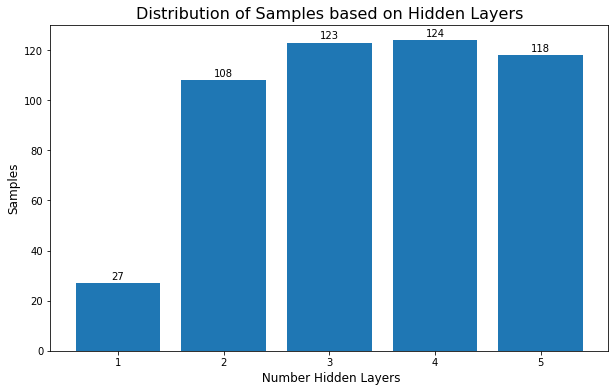

In [88]:
hidden_layers = []

for i in range(len(score)):
    hidden_layers.append(len(architectures[i]))

unique, counts = np.unique(hidden_layers, return_counts=True)

fig, axes = plt.subplots(figsize=(10, 6))
rects = axes.bar(unique, counts)

axes.set_xticks(unique)
axes.set_title("Distribution of Samples based on Hidden Layers", fontsize=16)
axes.set_xlabel(" Number Hidden Layers", fontsize=12)
axes.set_ylabel("Samples", fontsize=12)

for rect in rects:
        height = rect.get_height()
        axes.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 2),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
        
plt.show()

The distribution seems skewed towards the larger number of hidden networks. It was due to the selection of the hidden units with size multile of 100 during sampling. Doing so, no more than 27 samples of architecture with hidden layer 1 were possible in the range ``[300,3000)`` without any duplicates.

### Samples with accuracy above 95 %

In [83]:
print("=========+===============+===============+==========================")
print(" Sample\t | Val Accuracy\t | Hidden Layers | Hidden Units")
print("=========+===============+===============+==========================")
for i in range(len(score)):
    if score[i] >= 0.95:
        print(" %d\t | %.5f\t |  %d\t\t | %s "%(i+1, score[i], len(architectures[i]), str(architectures[i])))

print("=========+===============+===============+==========================")


=========+===============+===============+==========================
 Sample	 | Val Accuracy	 | Hidden Layers | Hidden Units
=========+===============+===============+==========================
 2	 | 0.95440	 |  1		 | [1500] 
 4	 | 0.95240	 |  1		 | [2300] 
 8	 | 0.95320	 |  1		 | [2700] 
 15	 | 0.95240	 |  1		 | [1000] 
 18	 | 0.95520	 |  1		 | [500] 
 21	 | 0.95200	 |  1		 | [2000] 
 32	 | 0.95720	 |  1		 | [900] 
 37	 | 0.95640	 |  1		 | [600] 
 56	 | 0.95640	 |  1		 | [700] 
 57	 | 0.95440	 |  1		 | [2600] 
 59	 | 0.95540	 |  1		 | [300] 
 60	 | 0.95620	 |  1		 | [1300] 
 69	 | 0.95600	 |  1		 | [1600] 
 82	 | 0.95300	 |  1		 | [2200] 
 83	 | 0.95180	 |  1		 | [1400] 
 86	 | 0.95580	 |  1		 | [2100] 
 91	 | 0.95840	 |  1		 | [1200] 
 95	 | 0.96260	 |  1		 | [2900] 
 98	 | 0.95120	 |  1		 | [1100] 
 99	 | 0.95460	 |  1		 | [400] 
 169	 | 0.95520	 |  1		 | [2800] 
 230	 | 0.95260	 |  1		 | [1700] 
 234	 | 0.95220	 |  2		 | [2900, 500] 
 245	 | 0.95540	 |  1		 | [2400] 
 264	 | 0.9544

Best accuracy seems to be for architectures with layer 1 and 2. 

The range of hidden unit was ``[300,3000)``.
The top 10 architeecture included the max range giving the possibility of larger size of hidden units to give better performance so we expand the hidden unit size to 4000

The lower range also gave preety good performance so it is expand it to 100 to check other possibilities

##  Fine Search

In [91]:

hidden_layers = [1,3] # 3 is exclusive
hidden_units = [100,4000]

search_params = {'hidden_layers':hidden_layers ,
                'hidden_units':hidden_units
}
sample_size = 500

#use sample_size >=200 for better tuning
score, architectures, best_comb = network_architecture_search(search_params , sample_size = sample_size)



Sample: 1 | Hidden Layers:2 | Hidden Units: [3500, 400] 
Training The Model...

Epoch 1/3
196/196 [==================== 100%] - 19.27s 98ms/step | loss: 0.3922 | acc: 0.9168 | val_loss: 0.1928 | val_acc: 0.9438
Epoch 2/3
196/196 [==================== 100%] - 21.85s 111ms/step | loss: 0.1233 | acc: 0.9625 | val_loss: 0.1659 | val_acc: 0.9520
Epoch 3/3
196/196 [==================== 100%] - 21.75s 110ms/step | loss: 0.1020 | acc: 0.9692 | val_loss: 0.2118 | val_acc: 0.9426

Total Training Time = 0hr 1mins 11secs 861.69ms

Sample: 2 | Hidden Layers:1 | Hidden Units: [200] 
Training The Model...

Epoch 1/3
196/196 [==================== 100%] - 0.97s 4ms/step | loss: 0.2477 | acc: 0.9239 | val_loss: 0.1845 | val_acc: 0.9460
Epoch 2/3
196/196 [==================== 100%] - 0.94s 4ms/step | loss: 0.1159 | acc: 0.9660 | val_loss: 0.1511 | val_acc: 0.9532
Epoch 3/3
196/196 [==================== 100%] - 0.95s 4ms/step | loss: 0.0870 | acc: 0.9737 | val_loss: 0.1371 | val_acc: 0.9558

Total Traini

196/196 [==================== 100%] - 69.84s 356ms/step | loss: 0.1708 | acc: 0.9520 | val_loss: 0.2519 | val_acc: 0.9370

Total Training Time = 0hr 3mins 54secs 83.44ms

Sample: 14 | Hidden Layers:2 | Hidden Units: [3400, 3400] 
Training The Model...

Epoch 1/3
196/196 [==================== 100%] - 83.85s 427ms/step | loss: 0.4897 | acc: 0.9054 | val_loss: 0.2569 | val_acc: 0.9312
Epoch 2/3
196/196 [==================== 100%] - 83.93s 428ms/step | loss: 0.1873 | acc: 0.9475 | val_loss: 0.2659 | val_acc: 0.9360
Epoch 3/3
196/196 [==================== 100%] - 83.65s 426ms/step | loss: 0.1883 | acc: 0.9486 | val_loss: 0.2892 | val_acc: 0.9298

Total Training Time = 0hr 4mins 35secs 424.40ms

Sample: 15 | Hidden Layers:2 | Hidden Units: [3900, 3900] 
Training The Model...

Epoch 1/3
196/196 [==================== 100%] - 107.17s 546ms/step | loss: 0.4732 | acc: 0.9040 | val_loss: 0.3016 | val_acc: 0.9202
Epoch 2/3
196/196 [==================== 100%] - 105.80s 539ms/step | loss: 0.2048 | ac

196/196 [==================== 100%] - 3.04s 15ms/step | loss: 0.2314 | acc: 0.9306 | val_loss: 0.1688 | val_acc: 0.9506
Epoch 2/3
196/196 [==================== 100%] - 3.03s 15ms/step | loss: 0.0972 | acc: 0.9705 | val_loss: 0.1702 | val_acc: 0.9522
Epoch 3/3
196/196 [==================== 100%] - 3.03s 15ms/step | loss: 0.0760 | acc: 0.9755 | val_loss: 0.1868 | val_acc: 0.9472

Total Training Time = 0hr 0mins 10secs 816.12ms

Sample: 40 | Hidden Layers:2 | Hidden Units: [3600, 3300] 
Training The Model...

Epoch 1/3
196/196 [==================== 100%] - 87.01s 443ms/step | loss: 0.5166 | acc: 0.8990 | val_loss: 0.2793 | val_acc: 0.9214
Epoch 2/3
196/196 [==================== 100%] - 86.98s 443ms/step | loss: 0.1911 | acc: 0.9459 | val_loss: 0.2667 | val_acc: 0.9368
Epoch 3/3
196/196 [==================== 100%] - 89.21s 455ms/step | loss: 0.1834 | acc: 0.9490 | val_loss: 0.2737 | val_acc: 0.9336

Total Training Time = 0hr 4mins 49secs 232.89ms

Sample: 41 | Hidden Layers:1 | Hidden Unit

Training The Model...

Epoch 1/3
196/196 [==================== 100%] - 9.36s 47ms/step | loss: 0.2754 | acc: 0.9311 | val_loss: 0.1930 | val_acc: 0.9432
Epoch 2/3
196/196 [==================== 100%] - 9.33s 47ms/step | loss: 0.0945 | acc: 0.9705 | val_loss: 0.1502 | val_acc: 0.9572
Epoch 3/3
196/196 [==================== 100%] - 9.32s 47ms/step | loss: 0.0731 | acc: 0.9771 | val_loss: 0.1532 | val_acc: 0.9574

Total Training Time = 0hr 0mins 32secs 313.68ms

Sample: 53 | Hidden Layers:2 | Hidden Units: [1400, 1300] 
Training The Model...

Epoch 1/3
196/196 [==================== 100%] - 15.91s 81ms/step | loss: 0.3885 | acc: 0.9110 | val_loss: 0.2141 | val_acc: 0.9388
Epoch 2/3
196/196 [==================== 100%] - 16.08s 82ms/step | loss: 0.1710 | acc: 0.9517 | val_loss: 0.2148 | val_acc: 0.9436
Epoch 3/3
196/196 [==================== 100%] - 16.30s 83ms/step | loss: 0.1538 | acc: 0.9568 | val_loss: 0.2127 | val_acc: 0.9470

Total Training Time = 0hr 0mins 54secs 987.38ms

Sample: 54 |

196/196 [==================== 100%] - 11.41s 58ms/step | loss: 0.2953 | acc: 0.9289 | val_loss: 0.1681 | val_acc: 0.9496
Epoch 2/3
196/196 [==================== 100%] - 10.91s 55ms/step | loss: 0.0991 | acc: 0.9699 | val_loss: 0.1528 | val_acc: 0.9580
Epoch 3/3
196/196 [==================== 100%] - 10.63s 54ms/step | loss: 0.0735 | acc: 0.9780 | val_loss: 0.1735 | val_acc: 0.9552

Total Training Time = 0hr 0mins 38secs 281.64ms

Sample: 66 | Hidden Layers:2 | Hidden Units: [1500, 600] 
Training The Model...

Epoch 1/3
196/196 [==================== 100%] - 13.70s 69ms/step | loss: 0.3849 | acc: 0.9089 | val_loss: 0.2217 | val_acc: 0.9384
Epoch 2/3
196/196 [==================== 100%] - 12.13s 61ms/step | loss: 0.1422 | acc: 0.9567 | val_loss: 0.1859 | val_acc: 0.9460
Epoch 3/3
196/196 [==================== 100%] - 12.16s 62ms/step | loss: 0.1260 | acc: 0.9618 | val_loss: 0.2113 | val_acc: 0.9428

Total Training Time = 0hr 0mins 43secs 751.82ms

Sample: 67 | Hidden Layers:2 | Hidden Units

Training The Model...

Epoch 1/3
196/196 [==================== 100%] - 47.47s 242ms/step | loss: 0.4684 | acc: 0.8989 | val_loss: 0.2883 | val_acc: 0.9240
Epoch 2/3
196/196 [==================== 100%] - 48.23s 246ms/step | loss: 0.2057 | acc: 0.9424 | val_loss: 0.2655 | val_acc: 0.9300
Epoch 3/3
196/196 [==================== 100%] - 46.48s 237ms/step | loss: 0.1839 | acc: 0.9484 | val_loss: 0.2280 | val_acc: 0.9374

Total Training Time = 0hr 2mins 38secs 135.04ms

Sample: 79 | Hidden Layers:2 | Hidden Units: [200, 2800] 
Training The Model...

Epoch 1/3
196/196 [==================== 100%] - 6.46s 32ms/step | loss: 0.4704 | acc: 0.8655 | val_loss: 0.3668 | val_acc: 0.8986
Epoch 2/3
196/196 [==================== 100%] - 7.27s 37ms/step | loss: 0.2812 | acc: 0.9210 | val_loss: 0.3044 | val_acc: 0.9166
Epoch 3/3
196/196 [==================== 100%] - 6.27s 31ms/step | loss: 0.2597 | acc: 0.9276 | val_loss: 0.3223 | val_acc: 0.9108

Total Training Time = 0hr 0mins 23secs 958.14ms

Sample: 80

Training The Model...

Epoch 1/3
196/196 [==================== 100%] - 29.70s 151ms/step | loss: 0.5064 | acc: 0.8998 | val_loss: 0.2570 | val_acc: 0.9276
Epoch 2/3
196/196 [==================== 100%] - 30.41s 155ms/step | loss: 0.1777 | acc: 0.9490 | val_loss: 0.2235 | val_acc: 0.9392
Epoch 3/3
196/196 [==================== 100%] - 29.73s 151ms/step | loss: 0.1804 | acc: 0.9499 | val_loss: 0.2261 | val_acc: 0.9394

Total Training Time = 0hr 1mins 41secs 598.42ms

Sample: 92 | Hidden Layers:2 | Hidden Units: [900, 3900] 
Training The Model...

Epoch 1/3
196/196 [==================== 100%] - 26.15s 133ms/step | loss: 0.5152 | acc: 0.8763 | val_loss: 0.3121 | val_acc: 0.9156
Epoch 2/3
196/196 [==================== 100%] - 30.14s 153ms/step | loss: 0.2556 | acc: 0.9298 | val_loss: 0.2771 | val_acc: 0.9190
Epoch 3/3
196/196 [==================== 100%] - 29.48s 150ms/step | loss: 0.2383 | acc: 0.9339 | val_loss: 0.2645 | val_acc: 0.9290

Total Training Time = 0hr 1mins 37secs 566.28ms

Samp

196/196 [==================== 100%] - 10.47s 53ms/step | loss: 0.2834 | acc: 0.9302 | val_loss: 0.1635 | val_acc: 0.9484
Epoch 2/3
196/196 [==================== 100%] - 10.40s 53ms/step | loss: 0.0934 | acc: 0.9717 | val_loss: 0.1684 | val_acc: 0.9550
Epoch 3/3
196/196 [==================== 100%] - 11.28s 57ms/step | loss: 0.0770 | acc: 0.9758 | val_loss: 0.1899 | val_acc: 0.9522

Total Training Time = 0hr 0mins 36secs 956.10ms

Sample: 105 | Hidden Layers:2 | Hidden Units: [1600, 1800] 
Training The Model...

Epoch 1/3
196/196 [==================== 100%] - 23.64s 120ms/step | loss: 0.4845 | acc: 0.9009 | val_loss: 0.2721 | val_acc: 0.9202
Epoch 2/3
196/196 [==================== 100%] - 22.80s 116ms/step | loss: 0.1884 | acc: 0.9466 | val_loss: 0.2504 | val_acc: 0.9364
Epoch 3/3
196/196 [==================== 100%] - 22.74s 116ms/step | loss: 0.1761 | acc: 0.9511 | val_loss: 0.2467 | val_acc: 0.9356

Total Training Time = 0hr 1mins 17secs 839.06ms

Sample: 106 | Hidden Layers:2 | Hidden

196/196 [==================== 100%] - 3.90s 19ms/step | loss: 0.3038 | acc: 0.9138 | val_loss: 0.2722 | val_acc: 0.9210
Epoch 2/3
196/196 [==================== 100%] - 3.62s 18ms/step | loss: 0.1622 | acc: 0.9522 | val_loss: 0.2297 | val_acc: 0.9372
Epoch 3/3
196/196 [==================== 100%] - 3.60s 18ms/step | loss: 0.1468 | acc: 0.9574 | val_loss: 0.2054 | val_acc: 0.9434

Total Training Time = 0hr 0mins 13secs 314.49ms

Sample: 118 | Hidden Layers:2 | Hidden Units: [3000, 3600] 
Training The Model...

Epoch 1/3
196/196 [==================== 100%] - 77.83s 397ms/step | loss: 0.4846 | acc: 0.8959 | val_loss: 0.2729 | val_acc: 0.9222
Epoch 2/3
196/196 [==================== 100%] - 77.74s 396ms/step | loss: 0.2160 | acc: 0.9391 | val_loss: 0.3197 | val_acc: 0.9234
Epoch 3/3
196/196 [==================== 100%] - 77.23s 394ms/step | loss: 0.2228 | acc: 0.9392 | val_loss: 0.2688 | val_acc: 0.9272

Total Training Time = 0hr 4mins 15secs 300.86ms

Sample: 119 | Hidden Layers:2 | Hidden Un

Training The Model...

Epoch 1/3
196/196 [==================== 100%] - 18.98s 96ms/step | loss: 0.4431 | acc: 0.8991 | val_loss: 0.3029 | val_acc: 0.9154
Epoch 2/3
196/196 [==================== 100%] - 18.76s 95ms/step | loss: 0.2000 | acc: 0.9441 | val_loss: 0.2587 | val_acc: 0.9324
Epoch 3/3
196/196 [==================== 100%] - 18.65s 95ms/step | loss: 0.1886 | acc: 0.9476 | val_loss: 0.2964 | val_acc: 0.9326

Total Training Time = 0hr 1mins 4secs 666.06ms

Sample: 131 | Hidden Layers:2 | Hidden Units: [3600, 400] 
Training The Model...

Epoch 1/3
196/196 [==================== 100%] - 21.91s 111ms/step | loss: 0.3914 | acc: 0.9159 | val_loss: 0.2076 | val_acc: 0.9388
Epoch 2/3
196/196 [==================== 100%] - 22.68s 115ms/step | loss: 0.1231 | acc: 0.9628 | val_loss: 0.1737 | val_acc: 0.9512
Epoch 3/3
196/196 [==================== 100%] - 22.34s 113ms/step | loss: 0.1107 | acc: 0.9662 | val_loss: 0.1769 | val_acc: 0.9510

Total Training Time = 0hr 1mins 15secs 863.13ms

Sample:

196/196 [==================== 100%] - 19.92s 101ms/step | loss: 0.4468 | acc: 0.8916 | val_loss: 0.3107 | val_acc: 0.9140
Epoch 2/3
196/196 [==================== 100%] - 19.69s 100ms/step | loss: 0.2286 | acc: 0.9371 | val_loss: 0.2667 | val_acc: 0.9242
Epoch 3/3
196/196 [==================== 100%] - 19.51s 99ms/step | loss: 0.2199 | acc: 0.9404 | val_loss: 0.2722 | val_acc: 0.9262

Total Training Time = 0hr 1mins 7secs 510.07ms

Sample: 144 | Hidden Layers:2 | Hidden Units: [3600, 1700] 
Training The Model...

Epoch 1/3
196/196 [==================== 100%] - 56.61s 288ms/step | loss: 0.3751 | acc: 0.9202 | val_loss: 0.2411 | val_acc: 0.9358
Epoch 2/3
196/196 [==================== 100%] - 56.67s 289ms/step | loss: 0.1551 | acc: 0.9559 | val_loss: 0.2369 | val_acc: 0.9308
Epoch 3/3
196/196 [==================== 100%] - 56.20s 286ms/step | loss: 0.1461 | acc: 0.9582 | val_loss: 0.2215 | val_acc: 0.9436

Total Training Time = 0hr 3mins 5secs 972.43ms

Sample: 145 | Hidden Layers:2 | Hidden

Training The Model...

Epoch 1/3
196/196 [==================== 100%] - 27.33s 139ms/step | loss: 0.4052 | acc: 0.9180 | val_loss: 0.2053 | val_acc: 0.9452
Epoch 2/3
196/196 [==================== 100%] - 27.27s 139ms/step | loss: 0.1321 | acc: 0.9597 | val_loss: 0.1904 | val_acc: 0.9454
Epoch 3/3
196/196 [==================== 100%] - 27.33s 139ms/step | loss: 0.1170 | acc: 0.9668 | val_loss: 0.1947 | val_acc: 0.9480

Total Training Time = 0hr 1mins 32secs 823.96ms

Sample: 157 | Hidden Layers:2 | Hidden Units: [3900, 400] 
Training The Model...

Epoch 1/3
196/196 [==================== 100%] - 23.57s 120ms/step | loss: 0.4896 | acc: 0.9097 | val_loss: 0.2227 | val_acc: 0.9346
Epoch 2/3
196/196 [==================== 100%] - 23.44s 119ms/step | loss: 0.1325 | acc: 0.9598 | val_loss: 0.1934 | val_acc: 0.9484
Epoch 3/3
196/196 [==================== 100%] - 23.47s 119ms/step | loss: 0.1103 | acc: 0.9674 | val_loss: 0.2038 | val_acc: 0.9462

Total Training Time = 0hr 1mins 19secs 876.22ms

Sam

196/196 [==================== 100%] - 11.38s 58ms/step | loss: 0.3774 | acc: 0.9082 | val_loss: 0.2036 | val_acc: 0.9432
Epoch 2/3
196/196 [==================== 100%] - 11.15s 56ms/step | loss: 0.1366 | acc: 0.9583 | val_loss: 0.1942 | val_acc: 0.9478
Epoch 3/3
196/196 [==================== 100%] - 11.26s 57ms/step | loss: 0.1144 | acc: 0.9658 | val_loss: 0.1790 | val_acc: 0.9492

Total Training Time = 0hr 0mins 38secs 846.25ms

Sample: 170 | Hidden Layers:2 | Hidden Units: [2100, 2100] 
Training The Model...

Epoch 1/3
196/196 [==================== 100%] - 36.89s 188ms/step | loss: 0.4355 | acc: 0.9030 | val_loss: 0.2814 | val_acc: 0.9236
Epoch 2/3
196/196 [==================== 100%] - 37.08s 189ms/step | loss: 0.1976 | acc: 0.9439 | val_loss: 0.2571 | val_acc: 0.9302
Epoch 3/3
196/196 [==================== 100%] - 38.73s 197ms/step | loss: 0.1797 | acc: 0.9490 | val_loss: 0.2699 | val_acc: 0.9336

Total Training Time = 0hr 2mins 4secs 751.24ms

Sample: 171 | Hidden Layers:2 | Hidden 

Training The Model...

Epoch 1/3
196/196 [==================== 100%] - 69.91s 356ms/step | loss: 0.4752 | acc: 0.9069 | val_loss: 0.2659 | val_acc: 0.9318
Epoch 2/3
196/196 [==================== 100%] - 69.60s 355ms/step | loss: 0.1905 | acc: 0.9474 | val_loss: 0.3093 | val_acc: 0.9180
Epoch 3/3
196/196 [==================== 100%] - 69.88s 356ms/step | loss: 0.1846 | acc: 0.9485 | val_loss: 0.2630 | val_acc: 0.9304

Total Training Time = 0hr 3mins 49secs 631.69ms

Sample: 183 | Hidden Layers:2 | Hidden Units: [1800, 900] 
Training The Model...

Epoch 1/3
196/196 [==================== 100%] - 15.50s 79ms/step | loss: 0.4613 | acc: 0.9042 | val_loss: 0.2434 | val_acc: 0.9260
Epoch 2/3
196/196 [==================== 100%] - 15.52s 79ms/step | loss: 0.1590 | acc: 0.9526 | val_loss: 0.2103 | val_acc: 0.9420
Epoch 3/3
196/196 [==================== 100%] - 15.46s 78ms/step | loss: 0.1486 | acc: 0.9575 | val_loss: 0.2025 | val_acc: 0.9500

Total Training Time = 0hr 0mins 52secs 940.53ms

Sample

196/196 [==================== 100%] - 13.86s 70ms/step | loss: 0.4673 | acc: 0.8829 | val_loss: 0.3069 | val_acc: 0.9108
Epoch 2/3
196/196 [==================== 100%] - 13.71s 69ms/step | loss: 0.2331 | acc: 0.9343 | val_loss: 0.2759 | val_acc: 0.9262
Epoch 3/3
196/196 [==================== 100%] - 13.63s 69ms/step | loss: 0.2280 | acc: 0.9381 | val_loss: 0.2827 | val_acc: 0.9246

Total Training Time = 0hr 0mins 47secs 367.32ms

Sample: 196 | Hidden Layers:2 | Hidden Units: [1900, 2500] 
Training The Model...

Epoch 1/3
196/196 [==================== 100%] - 38.79s 197ms/step | loss: 0.4440 | acc: 0.9028 | val_loss: 0.2612 | val_acc: 0.9246
Epoch 2/3
196/196 [==================== 100%] - 38.55s 196ms/step | loss: 0.1880 | acc: 0.9463 | val_loss: 0.2469 | val_acc: 0.9350
Epoch 3/3
196/196 [==================== 100%] - 38.45s 196ms/step | loss: 0.1767 | acc: 0.9500 | val_loss: 0.2237 | val_acc: 0.9414

Total Training Time = 0hr 2mins 9secs 13.87ms

Sample: 197 | Hidden Layers:2 | Hidden U

Training The Model...

Epoch 1/3
196/196 [==================== 100%] - 23.63s 120ms/step | loss: 0.4652 | acc: 0.8891 | val_loss: 0.2788 | val_acc: 0.9210
Epoch 2/3
196/196 [==================== 100%] - 23.60s 120ms/step | loss: 0.2450 | acc: 0.9303 | val_loss: 0.3121 | val_acc: 0.9174
Epoch 3/3
196/196 [==================== 100%] - 23.38s 119ms/step | loss: 0.2193 | acc: 0.9400 | val_loss: 0.2668 | val_acc: 0.9328

Total Training Time = 0hr 1mins 20secs 254.24ms

Sample: 209 | Hidden Layers:2 | Hidden Units: [2900, 1400] 
Training The Model...

Epoch 1/3
196/196 [==================== 100%] - 32.36s 165ms/step | loss: 0.4615 | acc: 0.9098 | val_loss: 0.2294 | val_acc: 0.9378
Epoch 2/3
196/196 [==================== 100%] - 32.22s 164ms/step | loss: 0.1650 | acc: 0.9521 | val_loss: 0.2269 | val_acc: 0.9414
Epoch 3/3
196/196 [==================== 100%] - 32.27s 164ms/step | loss: 0.1557 | acc: 0.9560 | val_loss: 0.2290 | val_acc: 0.9432

Total Training Time = 0hr 1mins 48secs 780.90ms

Sa

196/196 [==================== 100%] - 16.03s 81ms/step | loss: 0.4579 | acc: 0.8996 | val_loss: 0.3087 | val_acc: 0.9130
Epoch 2/3
196/196 [==================== 100%] - 15.63s 79ms/step | loss: 0.1994 | acc: 0.9428 | val_loss: 0.2795 | val_acc: 0.9306
Epoch 3/3
196/196 [==================== 100%] - 15.33s 78ms/step | loss: 0.1765 | acc: 0.9492 | val_loss: 0.2475 | val_acc: 0.9370

Total Training Time = 0hr 0mins 53secs 856.41ms

Sample: 222 | Hidden Layers:2 | Hidden Units: [900, 1700] 
Training The Model...

Epoch 1/3
196/196 [==================== 100%] - 11.87s 60ms/step | loss: 0.4049 | acc: 0.9011 | val_loss: 0.2698 | val_acc: 0.9262
Epoch 2/3
196/196 [==================== 100%] - 11.82s 60ms/step | loss: 0.2017 | acc: 0.9431 | val_loss: 0.2540 | val_acc: 0.9352
Epoch 3/3
196/196 [==================== 100%] - 11.72s 59ms/step | loss: 0.1884 | acc: 0.9471 | val_loss: 0.2600 | val_acc: 0.9326

Total Training Time = 0hr 0mins 40secs 733.03ms

Sample: 223 | Hidden Layers:2 | Hidden Uni

196/196 [==================== 100%] - 16.44s 83ms/step | loss: 0.3905 | acc: 0.9058 | val_loss: 0.2796 | val_acc: 0.9222
Epoch 2/3
196/196 [==================== 100%] - 16.57s 84ms/step | loss: 0.1715 | acc: 0.9500 | val_loss: 0.2354 | val_acc: 0.9366
Epoch 3/3
196/196 [==================== 100%] - 16.31s 83ms/step | loss: 0.1603 | acc: 0.9550 | val_loss: 0.2309 | val_acc: 0.9382

Total Training Time = 0hr 0mins 56secs 229.50ms

Sample: 235 | Hidden Layers:2 | Hidden Units: [200, 3500] 
Training The Model...

Epoch 1/3
196/196 [==================== 100%] - 6.57s 33ms/step | loss: 0.5918 | acc: 0.8397 | val_loss: 0.4004 | val_acc: 0.9038
Epoch 2/3
196/196 [==================== 100%] - 6.34s 32ms/step | loss: 0.3464 | acc: 0.9145 | val_loss: 0.3517 | val_acc: 0.9094
Epoch 3/3
196/196 [==================== 100%] - 6.36s 32ms/step | loss: 0.3055 | acc: 0.9259 | val_loss: 0.3315 | val_acc: 0.9188

Total Training Time = 0hr 0mins 22secs 862.51ms

Sample: 236 | Hidden Layers:2 | Hidden Units:

Training The Model...

Epoch 1/3
196/196 [==================== 100%] - 46.47s 237ms/step | loss: 0.4544 | acc: 0.9112 | val_loss: 0.2433 | val_acc: 0.9302
Epoch 2/3
196/196 [==================== 100%] - 46.55s 237ms/step | loss: 0.1604 | acc: 0.9525 | val_loss: 0.2111 | val_acc: 0.9376
Epoch 3/3
196/196 [==================== 100%] - 45.79s 233ms/step | loss: 0.1556 | acc: 0.9552 | val_loss: 0.2458 | val_acc: 0.9368

Total Training Time = 0hr 2mins 33secs 750.41ms

Sample: 248 | Hidden Layers:2 | Hidden Units: [1000, 500] 
Training The Model...

Epoch 1/3
196/196 [==================== 100%] - 6.85s 34ms/step | loss: 0.3437 | acc: 0.9138 | val_loss: 0.2193 | val_acc: 0.9314
Epoch 2/3
196/196 [==================== 100%] - 6.84s 34ms/step | loss: 0.1398 | acc: 0.9583 | val_loss: 0.2033 | val_acc: 0.9436
Epoch 3/3
196/196 [==================== 100%] - 7.04s 35ms/step | loss: 0.1266 | acc: 0.9636 | val_loss: 0.2014 | val_acc: 0.9478

Total Training Time = 0hr 0mins 24secs 150.99ms

Sample: 2

Training The Model...

Epoch 1/3
196/196 [==================== 100%] - 45.32s 231ms/step | loss: 0.4041 | acc: 0.9127 | val_loss: 0.2372 | val_acc: 0.9328
Epoch 2/3
196/196 [==================== 100%] - 44.39s 226ms/step | loss: 0.1636 | acc: 0.9536 | val_loss: 0.2291 | val_acc: 0.9398
Epoch 3/3
196/196 [==================== 100%] - 44.53s 227ms/step | loss: 0.1525 | acc: 0.9570 | val_loss: 0.2363 | val_acc: 0.9368

Total Training Time = 0hr 2mins 28secs 407.26ms

Sample: 261 | Hidden Layers:2 | Hidden Units: [3300, 1400] 
Training The Model...

Epoch 1/3
196/196 [==================== 100%] - 41.83s 213ms/step | loss: 0.4011 | acc: 0.9125 | val_loss: 0.2375 | val_acc: 0.9264
Epoch 2/3
196/196 [==================== 100%] - 42.78s 218ms/step | loss: 0.1555 | acc: 0.9531 | val_loss: 0.2268 | val_acc: 0.9362
Epoch 3/3
196/196 [==================== 100%] - 42.64s 217ms/step | loss: 0.1451 | acc: 0.9598 | val_loss: 0.2169 | val_acc: 0.9436

Total Training Time = 0hr 2mins 21secs 708.35ms

Sa

196/196 [==================== 100%] - 9.93s 50ms/step | loss: 0.3742 | acc: 0.9078 | val_loss: 0.2171 | val_acc: 0.9372
Epoch 2/3
196/196 [==================== 100%] - 9.84s 50ms/step | loss: 0.1614 | acc: 0.9529 | val_loss: 0.1985 | val_acc: 0.9452
Epoch 3/3
196/196 [==================== 100%] - 9.81s 50ms/step | loss: 0.1528 | acc: 0.9556 | val_loss: 0.2341 | val_acc: 0.9352

Total Training Time = 0hr 0mins 34secs 101.14ms

Sample: 274 | Hidden Layers:2 | Hidden Units: [1200, 400] 
Training The Model...

Epoch 1/3
196/196 [==================== 100%] - 7.38s 37ms/step | loss: 0.3352 | acc: 0.9126 | val_loss: 0.2294 | val_acc: 0.9342
Epoch 2/3
196/196 [==================== 100%] - 7.81s 39ms/step | loss: 0.1413 | acc: 0.9574 | val_loss: 0.2009 | val_acc: 0.9452
Epoch 3/3
196/196 [==================== 100%] - 7.66s 39ms/step | loss: 0.1271 | acc: 0.9610 | val_loss: 0.1922 | val_acc: 0.9450

Total Training Time = 0hr 0mins 26secs 545.97ms

Sample: 275 | Hidden Layers:2 | Hidden Units: [8

196/196 [==================== 100%] - 15.16s 77ms/step | loss: 0.4228 | acc: 0.8959 | val_loss: 0.2816 | val_acc: 0.9220
Epoch 2/3
196/196 [==================== 100%] - 15.18s 77ms/step | loss: 0.2249 | acc: 0.9388 | val_loss: 0.2744 | val_acc: 0.9284
Epoch 3/3
196/196 [==================== 100%] - 14.90s 76ms/step | loss: 0.2024 | acc: 0.9433 | val_loss: 0.2685 | val_acc: 0.9320

Total Training Time = 0hr 0mins 51secs 876.05ms

Sample: 287 | Hidden Layers:2 | Hidden Units: [1900, 3000] 
Training The Model...

Epoch 1/3
196/196 [==================== 100%] - 45.06s 229ms/step | loss: 0.4444 | acc: 0.9013 | val_loss: 0.2807 | val_acc: 0.9264
Epoch 2/3
196/196 [==================== 100%] - 44.97s 229ms/step | loss: 0.1993 | acc: 0.9448 | val_loss: 0.2657 | val_acc: 0.9296
Epoch 3/3
196/196 [==================== 100%] - 44.82s 228ms/step | loss: 0.1827 | acc: 0.9493 | val_loss: 0.2419 | val_acc: 0.9370

Total Training Time = 0hr 2mins 28secs 853.09ms

Sample: 288 | Hidden Layers:2 | Hidden

196/196 [==================== 100%] - 12.41s 63ms/step | loss: 0.4605 | acc: 0.8989 | val_loss: 0.2509 | val_acc: 0.9270
Epoch 2/3
196/196 [==================== 100%] - 12.38s 63ms/step | loss: 0.1771 | acc: 0.9484 | val_loss: 0.2261 | val_acc: 0.9358
Epoch 3/3
196/196 [==================== 100%] - 13.79s 70ms/step | loss: 0.1608 | acc: 0.9540 | val_loss: 0.2093 | val_acc: 0.9442

Total Training Time = 0hr 0mins 44secs 423.75ms

Sample: 300 | Hidden Layers:2 | Hidden Units: [1100, 2100] 
Training The Model...

Epoch 1/3
196/196 [==================== 100%] - 17.79s 90ms/step | loss: 0.5243 | acc: 0.8849 | val_loss: 0.2754 | val_acc: 0.9294
Epoch 2/3
196/196 [==================== 100%] - 17.10s 87ms/step | loss: 0.2127 | acc: 0.9379 | val_loss: 0.2605 | val_acc: 0.9264
Epoch 3/3
196/196 [==================== 100%] - 16.58s 84ms/step | loss: 0.1905 | acc: 0.9473 | val_loss: 0.2593 | val_acc: 0.9316

Total Training Time = 0hr 0mins 58secs 707.22ms

Sample: 301 | Hidden Layers:2 | Hidden Un

196/196 [==================== 100%] - 16.81s 85ms/step | loss: 0.4622 | acc: 0.8977 | val_loss: 0.2812 | val_acc: 0.9270
Epoch 2/3
196/196 [==================== 100%] - 16.69s 85ms/step | loss: 0.2050 | acc: 0.9431 | val_loss: 0.2607 | val_acc: 0.9332
Epoch 3/3
196/196 [==================== 100%] - 16.62s 84ms/step | loss: 0.1825 | acc: 0.9492 | val_loss: 0.2415 | val_acc: 0.9388

Total Training Time = 0hr 0mins 57secs 23.99ms

Sample: 313 | Hidden Layers:2 | Hidden Units: [2800, 100] 
Training The Model...

Epoch 1/3
196/196 [==================== 100%] - 12.99s 66ms/step | loss: 0.3839 | acc: 0.9007 | val_loss: 0.2093 | val_acc: 0.9402
Epoch 2/3
196/196 [==================== 100%] - 12.82s 65ms/step | loss: 0.1380 | acc: 0.9583 | val_loss: 0.1737 | val_acc: 0.9536
Epoch 3/3
196/196 [==================== 100%] - 13.23s 67ms/step | loss: 0.1070 | acc: 0.9673 | val_loss: 0.1645 | val_acc: 0.9542

Total Training Time = 0hr 0mins 44secs 920.43ms

Sample: 314 | Hidden Layers:2 | Hidden Unit

Training The Model...

Epoch 1/3
196/196 [==================== 100%] - 25.50s 130ms/step | loss: 0.4361 | acc: 0.9109 | val_loss: 0.1967 | val_acc: 0.9418
Epoch 2/3
196/196 [==================== 100%] - 25.61s 130ms/step | loss: 0.1490 | acc: 0.9558 | val_loss: 0.2044 | val_acc: 0.9440
Epoch 3/3
196/196 [==================== 100%] - 26.22s 133ms/step | loss: 0.1329 | acc: 0.9602 | val_loss: 0.2005 | val_acc: 0.9452

Total Training Time = 0hr 1mins 27secs 273.24ms

Sample: 326 | Hidden Layers:2 | Hidden Units: [2100, 3000] 
Training The Model...

Epoch 1/3
196/196 [==================== 100%] - 49.84s 254ms/step | loss: 0.5638 | acc: 0.8911 | val_loss: 0.2917 | val_acc: 0.9216
Epoch 2/3
196/196 [==================== 100%] - 49.84s 254ms/step | loss: 0.2140 | acc: 0.9390 | val_loss: 0.2564 | val_acc: 0.9348
Epoch 3/3
196/196 [==================== 100%] - 49.60s 253ms/step | loss: 0.1989 | acc: 0.9446 | val_loss: 0.2564 | val_acc: 0.9366

Total Training Time = 0hr 2mins 44secs 54.46ms

Sam

196/196 [==================== 100%] - 10.54s 53ms/step | loss: 0.3738 | acc: 0.9092 | val_loss: 0.1907 | val_acc: 0.9438
Epoch 2/3
196/196 [==================== 100%] - 10.54s 53ms/step | loss: 0.1259 | acc: 0.9615 | val_loss: 0.1929 | val_acc: 0.9460
Epoch 3/3
196/196 [==================== 100%] - 10.65s 54ms/step | loss: 0.1037 | acc: 0.9676 | val_loss: 0.1743 | val_acc: 0.9528

Total Training Time = 0hr 0mins 36secs 383.80ms

Sample: 339 | Hidden Layers:2 | Hidden Units: [3600, 1000] 
Training The Model...

Epoch 1/3
196/196 [==================== 100%] - 31.55s 160ms/step | loss: 0.4393 | acc: 0.9136 | val_loss: 0.2184 | val_acc: 0.9376
Epoch 2/3
196/196 [==================== 100%] - 31.11s 158ms/step | loss: 0.1460 | acc: 0.9572 | val_loss: 0.2460 | val_acc: 0.9352
Epoch 3/3
196/196 [==================== 100%] - 31.39s 160ms/step | loss: 0.1290 | acc: 0.9624 | val_loss: 0.1915 | val_acc: 0.9498

Total Training Time = 0hr 1mins 45secs 900.39ms

Sample: 340 | Hidden Layers:2 | Hidden

Training The Model...

Epoch 1/3
196/196 [==================== 100%] - 22.64s 115ms/step | loss: 0.4155 | acc: 0.9158 | val_loss: 0.1933 | val_acc: 0.9456
Epoch 2/3
196/196 [==================== 100%] - 22.51s 114ms/step | loss: 0.1292 | acc: 0.9608 | val_loss: 0.1871 | val_acc: 0.9476
Epoch 3/3
196/196 [==================== 100%] - 22.61s 115ms/step | loss: 0.1070 | acc: 0.9669 | val_loss: 0.1823 | val_acc: 0.9472

Total Training Time = 0hr 1mins 16secs 669.60ms

Sample: 352 | Hidden Layers:2 | Hidden Units: [3800, 1100] 
Training The Model...

Epoch 1/3
196/196 [==================== 100%] - 34.91s 178ms/step | loss: 0.4800 | acc: 0.9109 | val_loss: 0.2047 | val_acc: 0.9434
Epoch 2/3
196/196 [==================== 100%] - 34.86s 177ms/step | loss: 0.1448 | acc: 0.9564 | val_loss: 0.2163 | val_acc: 0.9424
Epoch 3/3
196/196 [==================== 100%] - 35.76s 182ms/step | loss: 0.1314 | acc: 0.9628 | val_loss: 0.2038 | val_acc: 0.9450

Total Training Time = 0hr 1mins 58secs 578.36ms

Sa

Training The Model...

Epoch 1/3
196/196 [==================== 100%] - 61.58s 314ms/step | loss: 0.5029 | acc: 0.8948 | val_loss: 0.2779 | val_acc: 0.9210
Epoch 2/3
196/196 [==================== 100%] - 61.59s 314ms/step | loss: 0.2085 | acc: 0.9400 | val_loss: 0.2805 | val_acc: 0.9262
Epoch 3/3
196/196 [==================== 100%] - 61.30s 312ms/step | loss: 0.1943 | acc: 0.9466 | val_loss: 0.2710 | val_acc: 0.9258

Total Training Time = 0hr 3mins 21secs 980.61ms

Sample: 365 | Hidden Layers:2 | Hidden Units: [3500, 3900] 
Training The Model...

Epoch 1/3
196/196 [==================== 100%] - 92.44s 471ms/step | loss: 0.5304 | acc: 0.9037 | val_loss: 0.2810 | val_acc: 0.9224
Epoch 2/3
196/196 [==================== 100%] - 92.24s 470ms/step | loss: 0.2036 | acc: 0.9437 | val_loss: 0.2738 | val_acc: 0.9310
Epoch 3/3
196/196 [==================== 100%] - 92.96s 474ms/step | loss: 0.1785 | acc: 0.9494 | val_loss: 0.2474 | val_acc: 0.9364

Total Training Time = 0hr 5mins 2secs 768.87ms

Sam

196/196 [==================== 100%] - 11.35s 57ms/step | loss: 0.4075 | acc: 0.9003 | val_loss: 0.2873 | val_acc: 0.9198
Epoch 2/3
196/196 [==================== 100%] - 11.28s 57ms/step | loss: 0.1870 | acc: 0.9462 | val_loss: 0.2149 | val_acc: 0.9418
Epoch 3/3
196/196 [==================== 100%] - 11.26s 57ms/step | loss: 0.1731 | acc: 0.9508 | val_loss: 0.2272 | val_acc: 0.9382

Total Training Time = 0hr 0mins 38secs 864.29ms

Sample: 378 | Hidden Layers:2 | Hidden Units: [1500, 3800] 
Training The Model...

Epoch 1/3
196/196 [==================== 100%] - 43.27s 220ms/step | loss: 0.5125 | acc: 0.8834 | val_loss: 0.3324 | val_acc: 0.9072
Epoch 2/3
196/196 [==================== 100%] - 43.31s 220ms/step | loss: 0.2353 | acc: 0.9332 | val_loss: 0.2757 | val_acc: 0.9266
Epoch 3/3
196/196 [==================== 100%] - 43.21s 220ms/step | loss: 0.2101 | acc: 0.9425 | val_loss: 0.2658 | val_acc: 0.9316

Total Training Time = 0hr 2mins 22secs 815.09ms

Sample: 379 | Hidden Layers:2 | Hidden

Training The Model...

Epoch 1/3
196/196 [==================== 100%] - 63.47s 323ms/step | loss: 0.4680 | acc: 0.9048 | val_loss: 0.2435 | val_acc: 0.9324
Epoch 2/3
196/196 [==================== 100%] - 63.11s 322ms/step | loss: 0.1760 | acc: 0.9497 | val_loss: 0.2546 | val_acc: 0.9324
Epoch 3/3
196/196 [==================== 100%] - 63.63s 324ms/step | loss: 0.1676 | acc: 0.9537 | val_loss: 0.2504 | val_acc: 0.9356

Total Training Time = 0hr 3mins 28secs 28.35ms

Sample: 391 | Hidden Layers:2 | Hidden Units: [2000, 3100] 
Training The Model...

Epoch 1/3
196/196 [==================== 100%] - 47.87s 244ms/step | loss: 0.5142 | acc: 0.8905 | val_loss: 0.2840 | val_acc: 0.9116
Epoch 2/3
196/196 [==================== 100%] - 47.47s 242ms/step | loss: 0.2216 | acc: 0.9358 | val_loss: 0.2876 | val_acc: 0.9224
Epoch 3/3
196/196 [==================== 100%] - 47.29s 241ms/step | loss: 0.2028 | acc: 0.9442 | val_loss: 0.2986 | val_acc: 0.9226

Total Training Time = 0hr 2mins 36secs 456.86ms

Sam

196/196 [==================== 100%] - 2.19s 11ms/step | loss: 0.4098 | acc: 0.8746 | val_loss: 0.3238 | val_acc: 0.9088
Epoch 2/3
196/196 [==================== 100%] - 2.07s 10ms/step | loss: 0.2413 | acc: 0.9326 | val_loss: 0.3007 | val_acc: 0.9174
Epoch 3/3
196/196 [==================== 100%] - 2.03s 10ms/step | loss: 0.2256 | acc: 0.9364 | val_loss: 0.2560 | val_acc: 0.9304

Total Training Time = 0hr 0mins 7secs 874.00ms

Sample: 404 | Hidden Layers:2 | Hidden Units: [3300, 3400] 
Training The Model...

Epoch 1/3
196/196 [==================== 100%] - 79.52s 405ms/step | loss: 0.4890 | acc: 0.8994 | val_loss: 0.2898 | val_acc: 0.9170
Epoch 2/3
196/196 [==================== 100%] - 78.97s 402ms/step | loss: 0.1985 | acc: 0.9448 | val_loss: 0.2637 | val_acc: 0.9308
Epoch 3/3
196/196 [==================== 100%] - 78.97s 402ms/step | loss: 0.2036 | acc: 0.9433 | val_loss: 0.2907 | val_acc: 0.9206

Total Training Time = 0hr 4mins 18secs 985.37ms

Sample: 405 | Hidden Layers:2 | Hidden Uni

Training The Model...

Epoch 1/3
196/196 [==================== 100%] - 78.95s 402ms/step | loss: 0.5095 | acc: 0.9006 | val_loss: 0.2970 | val_acc: 0.9204
Epoch 2/3
196/196 [==================== 100%] - 79.12s 403ms/step | loss: 0.2080 | acc: 0.9428 | val_loss: 0.2835 | val_acc: 0.9316
Epoch 3/3
196/196 [==================== 100%] - 79.11s 403ms/step | loss: 0.1978 | acc: 0.9453 | val_loss: 0.3050 | val_acc: 0.9168

Total Training Time = 0hr 4mins 18secs 748.79ms

Sample: 417 | Hidden Layers:2 | Hidden Units: [700, 1600] 
Training The Model...

Epoch 1/3
196/196 [==================== 100%] - 8.95s 45ms/step | loss: 0.3592 | acc: 0.9081 | val_loss: 0.2383 | val_acc: 0.9332
Epoch 2/3
196/196 [==================== 100%] - 8.85s 45ms/step | loss: 0.1901 | acc: 0.9447 | val_loss: 0.2551 | val_acc: 0.9274
Epoch 3/3
196/196 [==================== 100%] - 8.81s 44ms/step | loss: 0.1736 | acc: 0.9521 | val_loss: 0.2445 | val_acc: 0.9332

Total Training Time = 0hr 0mins 30secs 812.61ms

Sample: 4

196/196 [==================== 100%] - 20.00s 102ms/step | loss: 0.4577 | acc: 0.9021 | val_loss: 0.2695 | val_acc: 0.9226
Epoch 2/3
196/196 [==================== 100%] - 19.84s 101ms/step | loss: 0.1959 | acc: 0.9449 | val_loss: 0.2751 | val_acc: 0.9320
Epoch 3/3
196/196 [==================== 100%] - 19.88s 101ms/step | loss: 0.1904 | acc: 0.9482 | val_loss: 0.2963 | val_acc: 0.9330

Total Training Time = 0hr 1mins 7secs 993.62ms

Sample: 430 | Hidden Layers:2 | Hidden Units: [2000, 2500] 
Training The Model...

Epoch 1/3
196/196 [==================== 100%] - 39.56s 201ms/step | loss: 0.5518 | acc: 0.8970 | val_loss: 0.2659 | val_acc: 0.9260
Epoch 2/3
196/196 [==================== 100%] - 39.46s 201ms/step | loss: 0.1896 | acc: 0.9477 | val_loss: 0.2495 | val_acc: 0.9310
Epoch 3/3
196/196 [==================== 100%] - 39.22s 200ms/step | loss: 0.1856 | acc: 0.9484 | val_loss: 0.2604 | val_acc: 0.9276

Total Training Time = 0hr 2mins 11secs 598.39ms

Sample: 431 | Hidden Layers:2 | Hidd

196/196 [==================== 100%] - 6.17s 31ms/step | loss: 0.3710 | acc: 0.9066 | val_loss: 0.2172 | val_acc: 0.9402
Epoch 2/3
196/196 [==================== 100%] - 6.15s 31ms/step | loss: 0.1582 | acc: 0.9539 | val_loss: 0.1958 | val_acc: 0.9466
Epoch 3/3
196/196 [==================== 100%] - 6.12s 31ms/step | loss: 0.1420 | acc: 0.9597 | val_loss: 0.2202 | val_acc: 0.9436

Total Training Time = 0hr 0mins 21secs 570.96ms

Sample: 443 | Hidden Layers:2 | Hidden Units: [3000, 3300] 
Training The Model...

Epoch 1/3
196/196 [==================== 100%] - 71.40s 364ms/step | loss: 0.4912 | acc: 0.9031 | val_loss: 0.2501 | val_acc: 0.9316
Epoch 2/3
196/196 [==================== 100%] - 71.24s 363ms/step | loss: 0.2060 | acc: 0.9437 | val_loss: 0.2627 | val_acc: 0.9268
Epoch 3/3
196/196 [==================== 100%] - 71.00s 362ms/step | loss: 0.1885 | acc: 0.9481 | val_loss: 0.2599 | val_acc: 0.9344

Total Training Time = 0hr 3mins 53secs 267.95ms

Sample: 444 | Hidden Layers:2 | Hidden Un

Training The Model...

Epoch 1/3
196/196 [==================== 100%] - 39.99s 204ms/step | loss: 0.5172 | acc: 0.8895 | val_loss: 0.3107 | val_acc: 0.9180
Epoch 2/3
196/196 [==================== 100%] - 38.09s 194ms/step | loss: 0.2322 | acc: 0.9361 | val_loss: 0.3064 | val_acc: 0.9246
Epoch 3/3
196/196 [==================== 100%] - 37.43s 190ms/step | loss: 0.2299 | acc: 0.9389 | val_loss: 0.2960 | val_acc: 0.9280

Total Training Time = 0hr 2mins 7secs 561.14ms

Sample: 456 | Hidden Layers:2 | Hidden Units: [1800, 3500] 
Training The Model...

Epoch 1/3
196/196 [==================== 100%] - 47.91s 244ms/step | loss: 0.4943 | acc: 0.9007 | val_loss: 0.2916 | val_acc: 0.9192
Epoch 2/3
196/196 [==================== 100%] - 47.95s 244ms/step | loss: 0.2173 | acc: 0.9385 | val_loss: 0.3052 | val_acc: 0.9196
Epoch 3/3
196/196 [==================== 100%] - 47.87s 244ms/step | loss: 0.1972 | acc: 0.9451 | val_loss: 0.3072 | val_acc: 0.9212

Total Training Time = 0hr 2mins 38secs 39.22ms

Samp

Training The Model...

Epoch 1/3
196/196 [==================== 100%] - 30.05s 153ms/step | loss: 0.4310 | acc: 0.9068 | val_loss: 0.2381 | val_acc: 0.9362
Epoch 2/3
196/196 [==================== 100%] - 30.07s 153ms/step | loss: 0.1720 | acc: 0.9502 | val_loss: 0.2692 | val_acc: 0.9338
Epoch 3/3
196/196 [==================== 100%] - 29.89s 152ms/step | loss: 0.1616 | acc: 0.9549 | val_loss: 0.2184 | val_acc: 0.9460

Total Training Time = 0hr 1mins 41secs 355.01ms

Sample: 469 | Hidden Layers:2 | Hidden Units: [1600, 100] 
Training The Model...

Epoch 1/3
196/196 [==================== 100%] - 7.81s 39ms/step | loss: 0.3980 | acc: 0.8879 | val_loss: 0.2137 | val_acc: 0.9396
Epoch 2/3
196/196 [==================== 100%] - 7.39s 37ms/step | loss: 0.1389 | acc: 0.9578 | val_loss: 0.1888 | val_acc: 0.9464
Epoch 3/3
196/196 [==================== 100%] - 7.39s 37ms/step | loss: 0.1164 | acc: 0.9653 | val_loss: 0.1667 | val_acc: 0.9522

Total Training Time = 0hr 0mins 26secs 275.00ms

Sample: 4

196/196 [==================== 100%] - 6.54s 33ms/step | loss: 0.4215 | acc: 0.8875 | val_loss: 0.3084 | val_acc: 0.9168
Epoch 2/3
196/196 [==================== 100%] - 6.47s 32ms/step | loss: 0.2414 | acc: 0.9345 | val_loss: 0.3007 | val_acc: 0.9216
Epoch 3/3
196/196 [==================== 100%] - 6.30s 32ms/step | loss: 0.2235 | acc: 0.9413 | val_loss: 0.2771 | val_acc: 0.9234

Total Training Time = 0hr 0mins 22secs 802.41ms

Sample: 482 | Hidden Layers:2 | Hidden Units: [2900, 2300] 
Training The Model...

Epoch 1/3
196/196 [==================== 100%] - 55.54s 283ms/step | loss: 0.3980 | acc: 0.9146 | val_loss: 0.2669 | val_acc: 0.9250
Epoch 2/3
196/196 [==================== 100%] - 53.19s 271ms/step | loss: 0.1741 | acc: 0.9499 | val_loss: 0.2404 | val_acc: 0.9374
Epoch 3/3
196/196 [==================== 100%] - 56.66s 289ms/step | loss: 0.1678 | acc: 0.9515 | val_loss: 0.2298 | val_acc: 0.9366

Total Training Time = 0hr 3mins 1secs 626.55ms

Sample: 483 | Hidden Layers:2 | Hidden Uni

196/196 [==================== 100%] - 7.40s 37ms/step | loss: 0.4561 | acc: 0.8846 | val_loss: 0.2876 | val_acc: 0.9176
Epoch 2/3
196/196 [==================== 100%] - 7.46s 38ms/step | loss: 0.2154 | acc: 0.9382 | val_loss: 0.2619 | val_acc: 0.9292
Epoch 3/3
196/196 [==================== 100%] - 7.34s 37ms/step | loss: 0.1943 | acc: 0.9456 | val_loss: 0.2768 | val_acc: 0.9294

Total Training Time = 0hr 0mins 26secs 24.28ms

Sample: 495 | Hidden Layers:2 | Hidden Units: [600, 3000] 
Training The Model...

Epoch 1/3
196/196 [==================== 100%] - 12.73s 64ms/step | loss: 0.4240 | acc: 0.8952 | val_loss: 0.3071 | val_acc: 0.9220
Epoch 2/3
196/196 [==================== 100%] - 12.56s 64ms/step | loss: 0.2212 | acc: 0.9399 | val_loss: 0.2656 | val_acc: 0.9294
Epoch 3/3
196/196 [==================== 100%] - 12.45s 63ms/step | loss: 0.2203 | acc: 0.9384 | val_loss: 0.2715 | val_acc: 0.9268

Total Training Time = 0hr 0mins 43secs 730.74ms

Sample: 496 | Hidden Layers:2 | Hidden Units: 

## Overall Search Result Sorted

In [92]:
best_sorted_architectures = search_summary(score, architectures, top_best = 500)

Top 500 Best Architectures

=================+===============+====================================
 Val Accuracy	 | Hidden Layers | Hidden Units 
=================+===============+====================================
 0.96000	 |  1		 | [3700] 
 0.95960	 |  1		 | [800] 
 0.95920	 |  1		 | [3100] 
 0.95780	 |  1		 | [3800] 
 0.95740	 |  1		 | [2100] 
 0.95700	 |  1		 | [1100] 
 0.95680	 |  1		 | [1300] 
 0.95660	 |  1		 | [1200] 
 0.95620	 |  2		 | [400, 100] 
 0.95600	 |  1		 | [3500] 
 0.95600	 |  1		 | [900] 
 0.95600	 |  1		 | [1000] 
 0.95580	 |  1		 | [200] 
 0.95580	 |  1		 | [3400] 
 0.95520	 |  1		 | [2300] 
 0.95520	 |  1		 | [2400] 
 0.95520	 |  2		 | [3500, 200] 
 0.95500	 |  1		 | [1500] 
 0.95500	 |  1		 | [300] 
 0.95500	 |  1		 | [500] 
 0.95480	 |  2		 | [2100, 100] 
 0.95460	 |  1		 | [1400] 
 0.95440	 |  1		 | [2800] 
 0.95420	 |  1		 | [100] 
 0.95420	 |  1		 | [3200] 
 0.95420	 |  1		 | [3000] 
 0.95420	 |  2		 | [2800, 100] 
 0.95400	 |  1		 | [3600] 
 0.95400	 |  1

### Top 10 best Results

In [93]:
best_sorted_architectures = search_summary(score, architectures, top_best = 10)

Top 10 Best Architectures

=================+===============+====================================
 Val Accuracy	 | Hidden Layers | Hidden Units 
=================+===============+====================================
 0.96000	 |  1		 | [3700] 
 0.95960	 |  1		 | [800] 
 0.95920	 |  1		 | [3100] 
 0.95780	 |  1		 | [3800] 
 0.95740	 |  1		 | [2100] 
 0.95700	 |  1		 | [1100] 
 0.95680	 |  1		 | [1300] 
 0.95660	 |  1		 | [1200] 
 0.95620	 |  2		 | [400, 100] 
 0.95600	 |  1		 | [3500] 
=================+===============+====================================

Best Score: 0.960000 
Best Architcture: [3700]


## Search Analysis

### Sample Distribution based on hidden layers

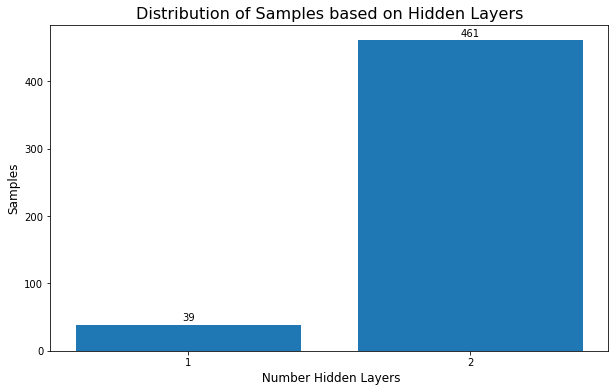

In [94]:
hidden_layers = []

for i in range(len(score)):
    hidden_layers.append(len(architectures[i]))

unique, counts = np.unique(hidden_layers, return_counts=True)

fig, axes = plt.subplots(figsize=(10, 6))
rects = axes.bar(unique, counts)

axes.set_xticks(unique)
axes.set_title("Distribution of Samples based on Hidden Layers", fontsize=16)
axes.set_xlabel(" Number Hidden Layers", fontsize=12)
axes.set_ylabel("Samples", fontsize=12)

for rect in rects:
        height = rect.get_height()
        axes.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 2),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
        
plt.show()

The skewed distribution is due to the same reason as discussed in Coarse search 

### Samples with accuracy above 95 %

In [95]:
print("=========+===============+===============+==========================")
print(" Sample\t | Val Accuracy\t | Hidden Layers | Hidden Units")
print("=========+===============+===============+==========================")
for i in range(len(score)):
    if score[i] >= 0.95:
        print(" %d\t | %.5f\t |  %d\t\t | %s "%(i+1, score[i], len(architectures[i]), str(architectures[i])))

print("=========+===============+===============+==========================")


=========+===============+===============+==========================
 Sample	 | Val Accuracy	 | Hidden Layers | Hidden Units
=========+===============+===============+==========================
 2	 | 0.95580	 |  1		 | [200] 
 3	 | 0.95340	 |  1		 | [2900] 
 6	 | 0.95500	 |  1		 | [1500] 
 11	 | 0.95920	 |  1		 | [3100] 
 22	 | 0.95240	 |  1		 | [2600] 
 25	 | 0.95400	 |  1		 | [3600] 
 26	 | 0.95500	 |  1		 | [300] 
 30	 | 0.95280	 |  1		 | [2000] 
 31	 | 0.95960	 |  1		 | [800] 
 32	 | 0.95660	 |  1		 | [1200] 
 34	 | 0.95500	 |  1		 | [500] 
 36	 | 0.95400	 |  1		 | [2200] 
 37	 | 0.95320	 |  1		 | [3900] 
 38	 | 0.95600	 |  1		 | [3500] 
 41	 | 0.95600	 |  1		 | [900] 
 42	 | 0.95020	 |  1		 | [400] 
 45	 | 0.95420	 |  1		 | [100] 
 46	 | 0.95780	 |  1		 | [3800] 
 52	 | 0.95740	 |  1		 | [2100] 
 64	 | 0.95360	 |  2		 | [200, 200] 
 65	 | 0.95520	 |  1		 | [2300] 
 68	 | 0.95420	 |  1		 | [3200] 
 70	 | 0.95420	 |  1		 | [3000] 
 73	 | 0.95380	 |  1		 | [1800] 
 75	 | 0.95460	 |  1

### Selected Candidates

The candidates are selected from among the top performing candiadtes in both the searches. Some of the candidate with hidden units close to those given below are omitted despite good performance because despite change in some parameters the variation in performance is assumed to be minimum.
<pre>
From my search
========+==============+===============+==============
 Sample | Val Accuracy | Hidden Layers | Hidden Units
========+==============+===============+==============
    1   | 0.96260      |  1            | [2900] 
    2   | 0.96000      |  1            | [3700] 
    3   | 0.95960      |  1            | [800] 
    4   | 0.95920      |  1            | [3100]  
    5   | 0.95840      |  1            | [1200] 
    6   | 0.95740      |  1            | [2100] 
========+==============+===============+==============
</pre>

A number of possible candidates with varied architecture were selected because of their close performance provided that the dropout parameter was constant. Change in this parameter may result in change in the performance of the individual architecture surpassing eachother.

Given the fixed configuration of hyperparameters and data size, the search performed above found architecture with 1 hidden layers to have best performance. Despite that literatures show other architecture with varied number of hidden layers to have better performances as well (which varies a lot based on techniques used in data preprocessing and augmentation, optimization techniques, and other training methodologies like ensamble, committee). 

Despite some varition in those techniques the following architectures with varied hidden layer sizes were selected from different literature to test during some of my tuning process.

<pre>
Architecture found best in literatures
=========+===============+============================+===============================================================================
 Sample  |Hidden Layers  | Hidden Units               | Ref
=========+===============+============================+===============================================================================
    9    |  2            | [800,800]                  | Regularization of Neural Networks using DropConnect, lecun's site(simard 0.7)
    8    |  3            | [1500,1000,500]            | Deep Big Simple Neural Nets Excel on Hand- written Digit Recognition
    7    |  4            | [1024,1024,1024,1024]      | Dropout : A Simple Way to Prevent Neural Networks from Overfitting
   10    |  5            | [2500,2000,1500,1000,500]  | Deep Big Simple Neural Nets Excel on Hand- written Digit Recognition
=========+===============+============================+===============================================================================   
</pre>

Only the best architecture found during the tuning of the dropout parameter in experiment 6 will be used for further tuning to prepare the final model.

In [99]:
import os
!jupyter-nbconvert --to html 'Hyper Parameter Tuning -Network Architecture Search .ipynb' --output Experiments/experiment-5/architecture_search_500_samples_complete_analysis.html 


[NbConvertApp] Converting notebook Hyper Parameter Tuning -Network Architecture Search .ipynb to html
[NbConvertApp] Writing 1078150 bytes to Experiments/experiment-5/architecture_search_500_samples_complete_analysis.html
